In [1]:
import torch
from data.utils.dataloaders import get_imagenet_dataloader
import json
from data.utils.dataloaders import ReconstructionDataset
import numpy as np
from torch.utils.data import DataLoader, Dataset
from models.bpp_predictor import CompressionRatePredictor
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from collections import defaultdict
from typing import Sequence, Dict, List, Tuple
import imageio
import os
from pathlib import Path
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
from sklearn.linear_model import LinearRegression


linear_regressor = LinearRegression()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the ImageNet dataloader
batch_size = 8
imgnet_dataloader = get_imagenet_dataloader(batch_size=batch_size)
print("Dataloader loaded successfully.")

Dataloader loaded successfully.


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [121]:
# this is used for entropy coding, it holds the registers for each image
# e.g., [[registers], [registers], ...] found by flextok.
with open("/BS/data_mani_compress/work/thesis/thesis/all_registers_imagenet.json", "r") as f:
    all_registers = json.load(f)

# Load the LID values for lid_25_corrected
lid_25_path = "/BS/data_mani_compress/work/thesis/thesis/imageNet_LID_values/lid_25_corrected.json"
with open(lid_25_path, "r") as f:
    lid_25_values = json.load(f)

# Load the reconstruction errors
reconstruction_error_path_70 = "/BS/data_mani_compress/work/thesis/thesis/reconstruction_loss_imgnet/reconstruction_errors.json_0000_0070.json"
with open(reconstruction_error_path_70, "r") as f:
    reconstruction_error_70 = json.load(f)

reconstruction_error_path_140 = "/BS/data_mani_compress/work/thesis/thesis/reconstruction_loss_imgnet/reconstruction_errors.json_0070_0140.json"
with open(reconstruction_error_path_140, "r") as f:
    reconstruction_error_140 = json.load(f)

reconstruction_error_path_210 = "/BS/data_mani_compress/work/thesis/thesis/reconstruction_loss_imgnet/reconstruction_errors.json_0140_0210.json"
with open(reconstruction_error_path_210, "r") as f:
    reconstruction_error_210 = json.load(f)

# load the density value 
json_path = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities.json"
with open(json_path, "r") as f:
    density_results = json.load(f)

density_rf_1 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_1.json"
with open(density_rf_1, "r") as f:
    density_rf_1 = json.load(f)

density_rf_16 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_16.json"
with open(density_rf_16, "r") as f:
    density_rf_16 = json.load(f)


density_rf_32 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_32.json"
with open(density_rf_32, "r") as f:
    density_rf_32 = json.load(f)

density_rf_64 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_64.json"
with open(density_rf_64, "r") as f:
    density_rf_64 = json.load(f)

density_rf_128 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_128.json"
with open(density_rf_128, "r") as f:
    density_rf_128 = json.load(f)

density_rf_256 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_256.json"
with open(density_rf_256, "r") as f:
    density_rf_256 = json.load(f)


# compare density values with different compression rates
avg_1 = np.mean(density_rf_1)
avg_16 = np.mean(density_rf_16)
avg_32 = np.mean(density_rf_32)
avg_64 = np.mean(density_rf_64)
avg_128 = np.mean(density_rf_128)
avg_256 = np.mean(density_rf_256)
print(f"Average Density RF 1: {avg_1}")
print(f"Average Density RF 16: {avg_16}")
print(f"Average Density RF 32: {avg_32}")
print(f"Average Density RF 64: {avg_64}")
print(f"Average Density RF 128: {avg_128}")
print(f"Average Density RF 256: {avg_256}")



Average Density RF 1: 9171.372196592134
Average Density RF 16: 9316.91728536717
Average Density RF 32: 9374.511480726795
Average Density RF 64: 9412.423222782802
Average Density RF 128: 9563.219730762768
Average Density RF 256: 9648.385132701684


In [4]:
# concatenate all the reconstruction errors
reconstruction_error = reconstruction_error_70 + reconstruction_error_140 + reconstruction_error_210
lid_filtered_normalized = (((lid_25_values - np.mean(lid_25_values)) / np.std(lid_25_values))) + 0.5 

In [5]:
def group_equal_lid_and_density(
    lid_vals,logp_vals, lid_tol: float = 1e-3, logp_tol: float = 1e-2): 
    """
    Cluster indices whose (LID, logp) pairs are equal up to the given tolerances.

    Args
    ----
    lid_vals   : iterable of LID estimates  (len = N)
    logp_vals  : iterable of unconditional log-densities (len = N)
    lid_tol    : two LIDs are considered equal if |lid_i - lid_j| <= lid_tol
    logp_tol   : two log-p's are equal if |logp_i - logp_j| <= logp_tol
    
    Returns
    -------
    groups : dict mapping group_id -> list of indices
             Only groups with at least *two* members are kept.
    """
    lid_vals  = np.asarray(lid_vals,  dtype=float)
    logp_vals = np.asarray(logp_vals, dtype=float)
    assert lid_vals.shape == logp_vals.shape, "lid_vals and logp_vals must align"

    # round to tolerance‑controlled bins so equality can be tested with hashable keys
    # Quantise each value into an integer bin
    # Idea: two floats are “the same” if they land in the same bin.
    lid_bins  = np.round(lid_vals  / lid_tol ).astype(int)
    logp_bins = np.round(logp_vals / logp_tol).astype(int)

    buckets = defaultdict(list)
    for idx, (lid_b, logp_b) in enumerate(zip(lid_bins, logp_bins)):
        buckets[(lid_b, logp_b)].append(idx)

    # keep only groups with ≥2 members
    return {gid: idxs for gid, idxs in buckets.items() if len(idxs) > 1}

groups = group_equal_lid_and_density(lid_25_values[:6719], density_results[:6719],
                                     lid_tol=2.1,
                                     logp_tol=2.5)

for gid, idxs in groups.items():
    print(f"group {gid}: indices {idxs}")




group (-2107828, -721): indices [1336, 4512]
group (-2196919, -775): indices [3624, 5759]


[1336, 4512]
group (-2107828, -721)  |  size = 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].


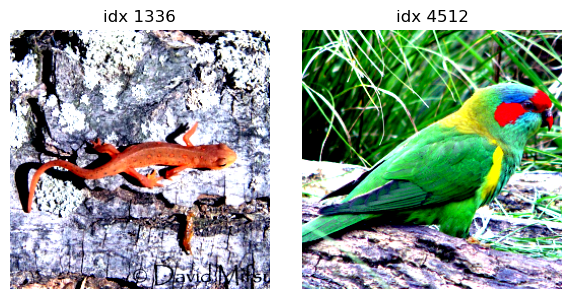

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4133916..1.4703313].


[3624, 5759]
group (-2196919, -775)  |  size = 2


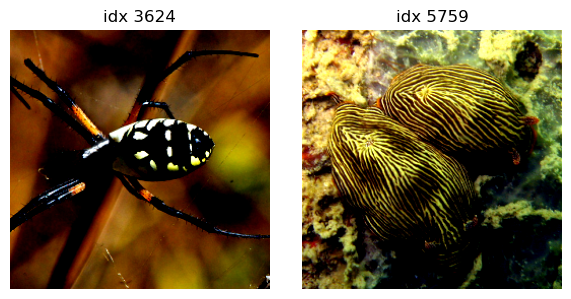

In [6]:
def show_images_from_group(
    idx_list: Sequence[int],
    dataset,
    *,
    max_images: int = 5,
) -> None:
    """
    Display up to `max_images` images whose indices are in `idx_list`.

    Args
    ----
    idx_list   : iterable with dataset indices (e.g. groups[key])
    dataset    : any PyTorch dataset returning (image, label) or (image, *).
                 Assumes image is a CHW tensor in [0,1] or [-1,1].
    max_images : cap on how many pictures to show.
    """
    
    n = min(len(idx_list), max_images)
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))

    # axes is not iterable when n == 1
    if n == 1:
        axes = [axes]

    for ax, idx in zip(axes, idx_list[:n]):
        img, *_ = dataset[idx]                # ignore label/extra
        if isinstance(img, torch.Tensor):
            img = img.cpu()

        # de‑normalise common [-1,1] range to [0,1] for imshow
        if img.min() < 0:
            img = (img + 1) / 2

        # CHW -> HWC if needed
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = img.permute(1, 2, 0)

        ax.imshow(img.numpy())
        ax.set_title(f"idx {idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


for gid, idxs in groups.items():          # gid = (lid_bin, logp_bin)
    print(idxs)
    print(f"group {gid}  |  size = {len(idxs)}")
    show_images_from_group(idxs, imgnet_dataloader.dataset, max_images=2)


In [9]:
from flextok.flextok_wrapper import FlexTokFromHub

flextok = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d28_dfn').to(device).eval()

In [7]:
recon_dataset = ReconstructionDataset(
        reconstruction_data=reconstruction_error,
        all_registers=all_registers,
        num_pixels=256*256,
        dataloader=imgnet_dataloader,
    )

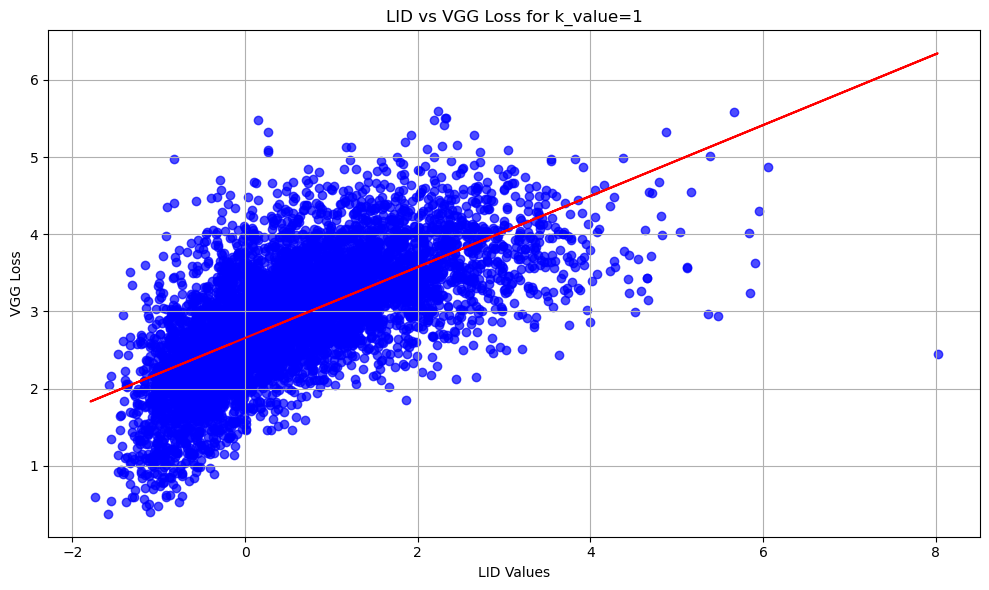

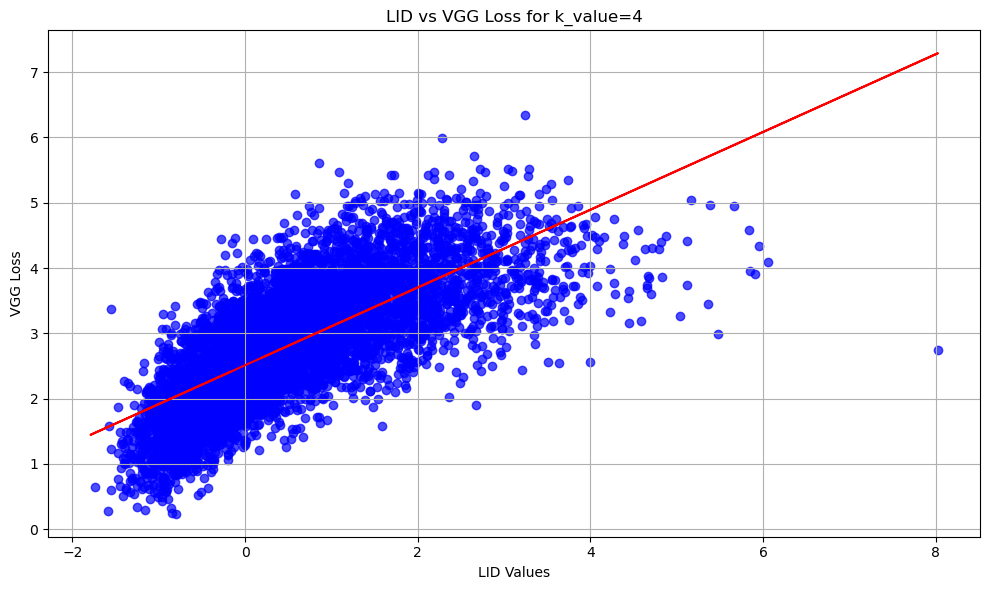

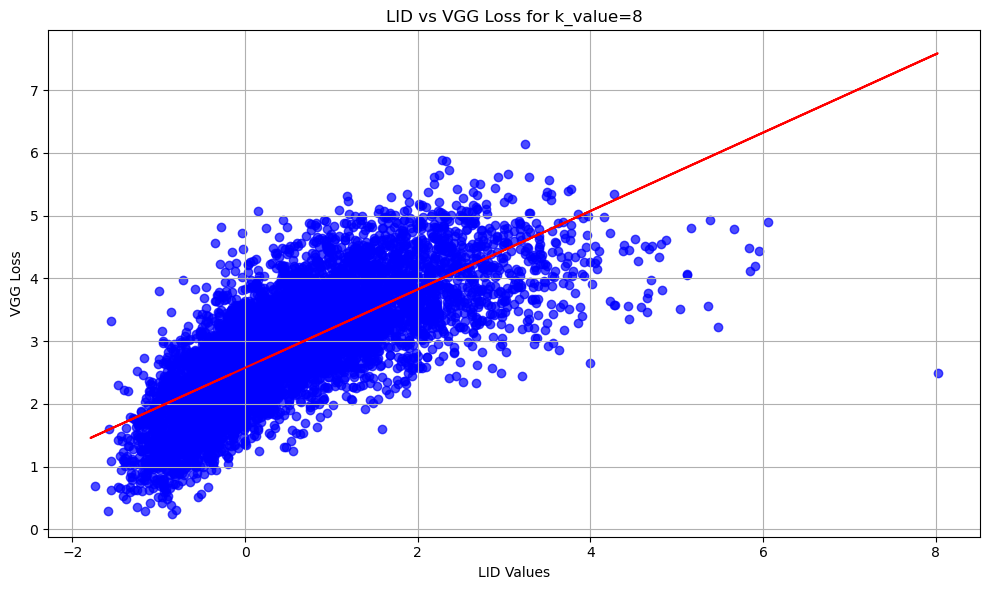

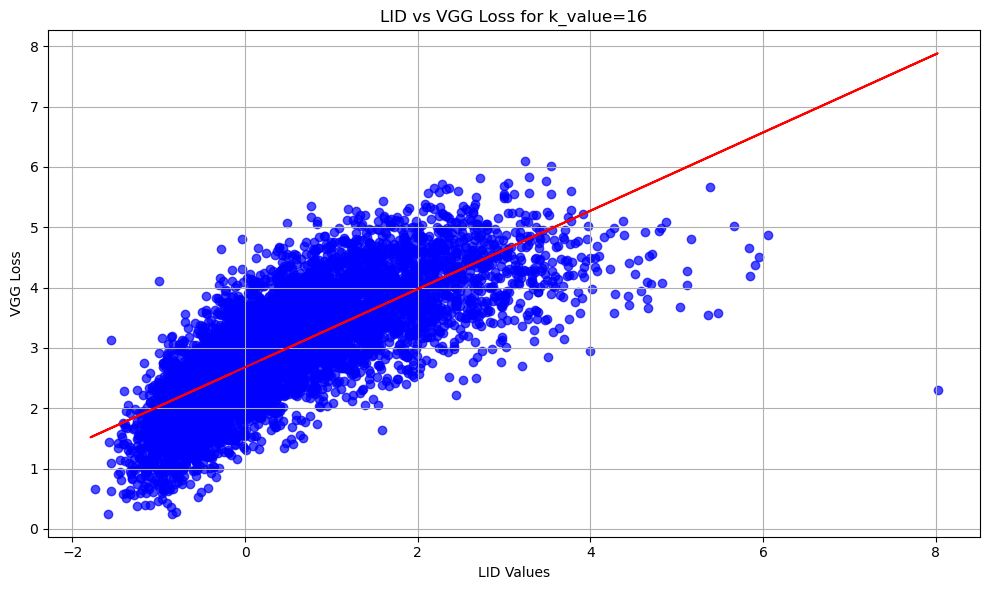

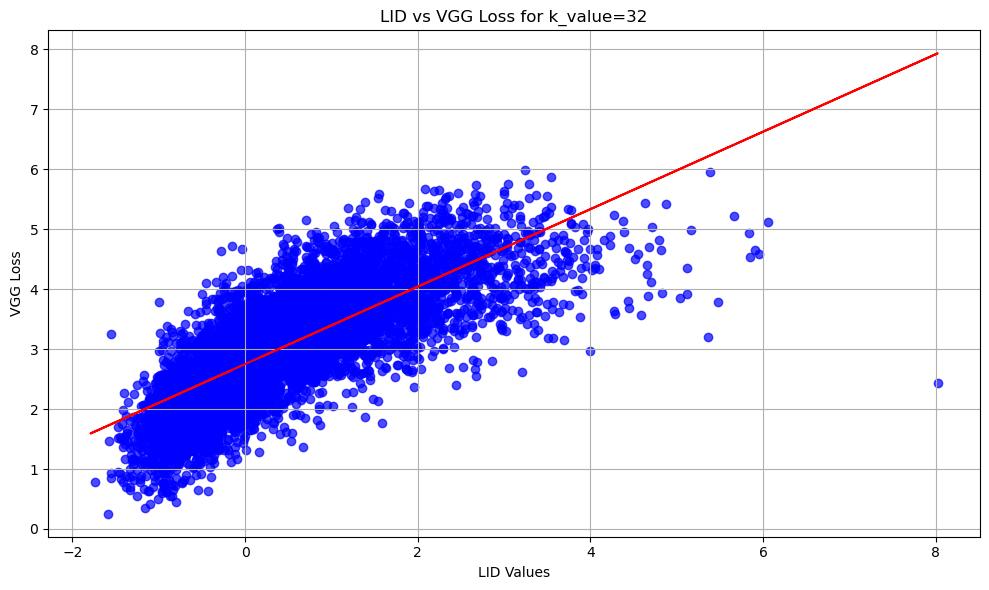

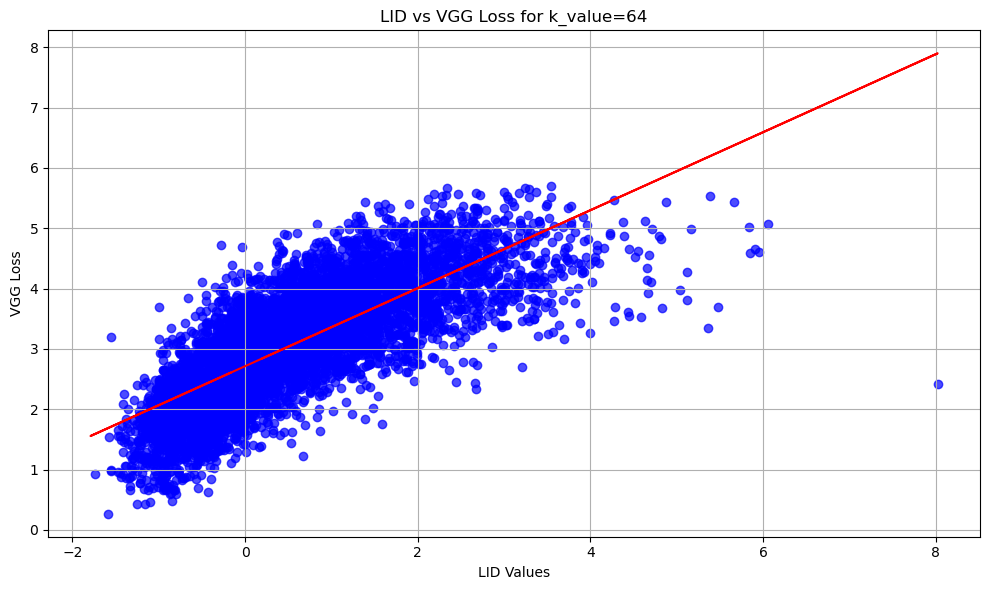

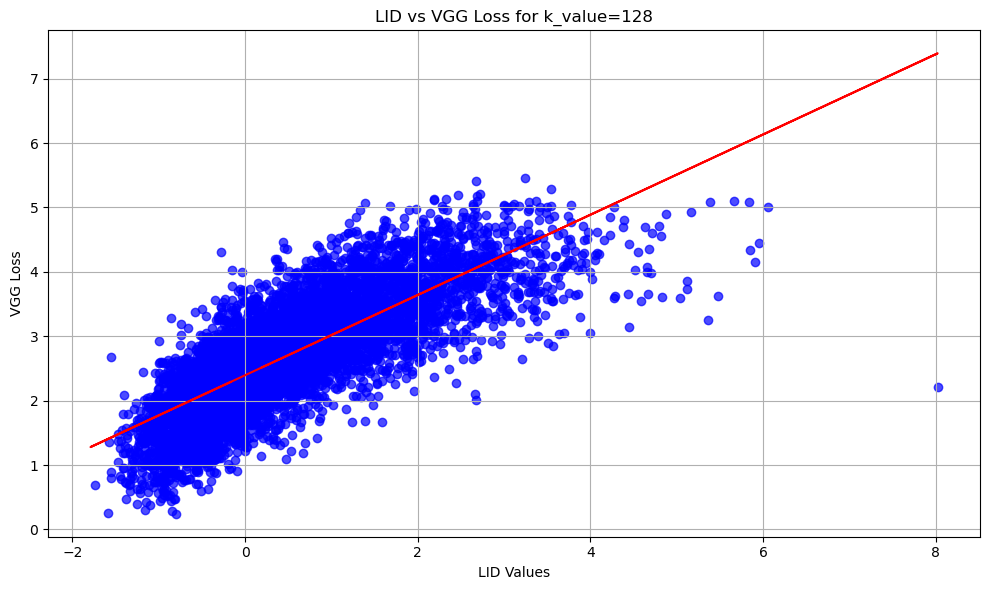

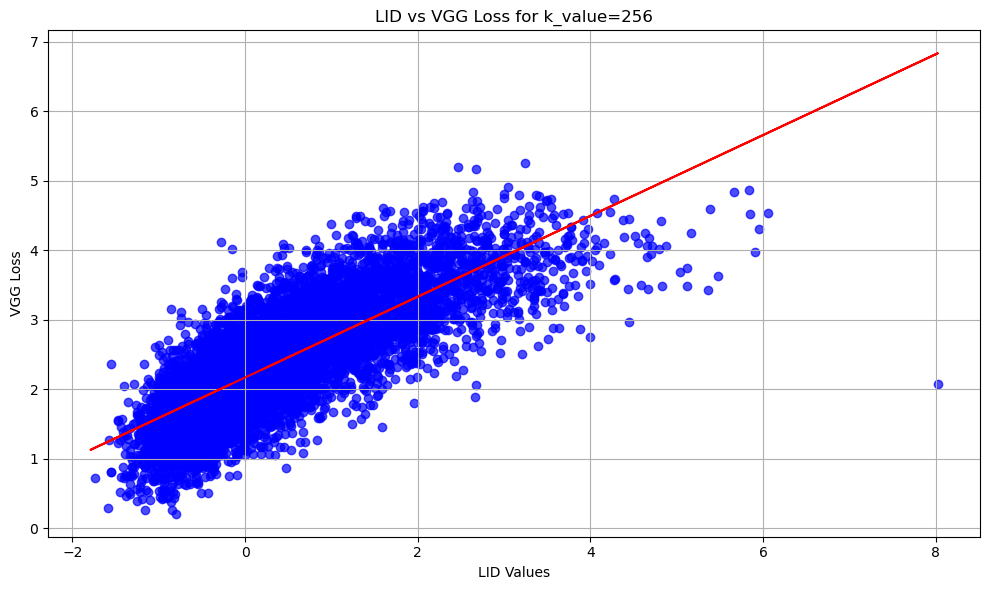

Slopes for each k_value:
k_value=1: slope=0.460
k_value=4: slope=0.595
k_value=8: slope=0.625
k_value=16: slope=0.648
k_value=32: slope=0.646
k_value=64: slope=0.646
k_value=128: slope=0.623
k_value=256: slope=0.582


In [ ]:

# Pick a certain k_value (e.g., k_value = 32)


k_values = [1,4,8,16,32,64,128,256]
slopes_normalized = {}
slopes = {}

lid_normalized = (((lid_25_values - np.mean(lid_25_values)) / np.std(lid_25_values))) + 0.5


for k_value in k_values:
    filtered = [entry for entry in reconstruction_error if entry['k_value'] == k_value]
    mse_loss = [entry['vgg_error'] for entry in filtered]


     # Fit a linear regression model
    linear_regressor.fit(np.array(lid_normalized[:len(mse_loss)]).reshape(-1, 1), np.array(mse_loss).reshape(-1, 1))

    # Get the slope (coefficient of LID)
    slope = linear_regressor.coef_[0]
    slopes[k_value] = slope


    # Fit a linear regression model
    linear_regressor.fit(np.array(lid_normalized[:len(mse_loss)]).reshape(-1, 1), np.array(mse_loss).reshape(-1, 1))

    # Get the slope (coefficient of LID)
    slope = linear_regressor.coef_[0]
    slopes_normalized[k_value] = slope



    # Plot LID vs MSE loss
    plt.figure(figsize=(10, 6))
    # draw a red line for the slope
    plt.plot(lid_normalized, linear_regressor.predict(np.array(lid_normalized).reshape(-1, 1)), color='r', label='Linear Fit')
    
    plt.scatter(lid_normalized[:len(mse_loss)], mse_loss, color='b', alpha=0.7)
    plt.xlabel("LID Values")
    plt.ylabel("VGG Loss")
    plt.title(f"LID vs VGG Loss for k_value={k_value}")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Print slopes for each k_value
print("Slopes for each k_value:")
# Print slopes for each k_value for both normalized and non-normalized LID values
for k in k_values:
    print(f"k_value={k}: slope={slopes_normalized[k][0]:.3f}")

In [ ]:
# see how well the linear regression fits the data
# y_pred = linear_regressor.predict(lid_filtered_normalized.reshape(-1, 1))
# error = y_pred - np.array(mse_loss).reshape(-1, 1)
# print(sum(abs(error))/ len(error))

In [ ]:
# 3.1 Load model for density estimation
checkpoint = torch.load('/BS/data_mani_compress/work/thesis/thesis/external/DenseFlow/denseflow/imn64/imagenet64/check/checkpoint.pt', map_location='cuda')

/tmp/ipykernel_1271179/2007594694.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/BS/data_mani_compress/work/thesis/thesis/external/DenseFlow/d

In [ ]:
from experiments.image.model.dense_flow import DenseFlow


density_estimator_model = DenseFlow(data_shape=(3, 64, 64),                  # ImageNet64
    block_config=[6, 4, 1],
    layers_config=[5, 6, 20],
    layer_mid_chnls=[48, 48, 48],
    growth_rate=10)
density_estimator_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:


def resize_with_box(tensor_batch, size=(64, 64)):
    resized = []
    for img in tensor_batch:  # assumes shape [B, 3, H, W]
        pil_img = to_pil_image(img)  # converts to PIL Image
        pil_resized = pil_img.resize(size, resample=Image.BOX)
        tensor_resized = to_tensor(pil_resized)  # back to tensor
        resized.append(tensor_resized)
    return torch.stack(resized)

In [14]:

# normalize LID values
#density_results = np.array(density_results[:num_images])
density_normalized = (((density_results - np.mean(density_results)) / np.std(density_results))) + 0.5


In [48]:
min_len = min(len(density_rf_1), len(density_rf_16), len(density_rf_32), len(density_rf_64), len(density_rf_128), len(density_rf_256))
print("min len:", min_len)

min len: 670


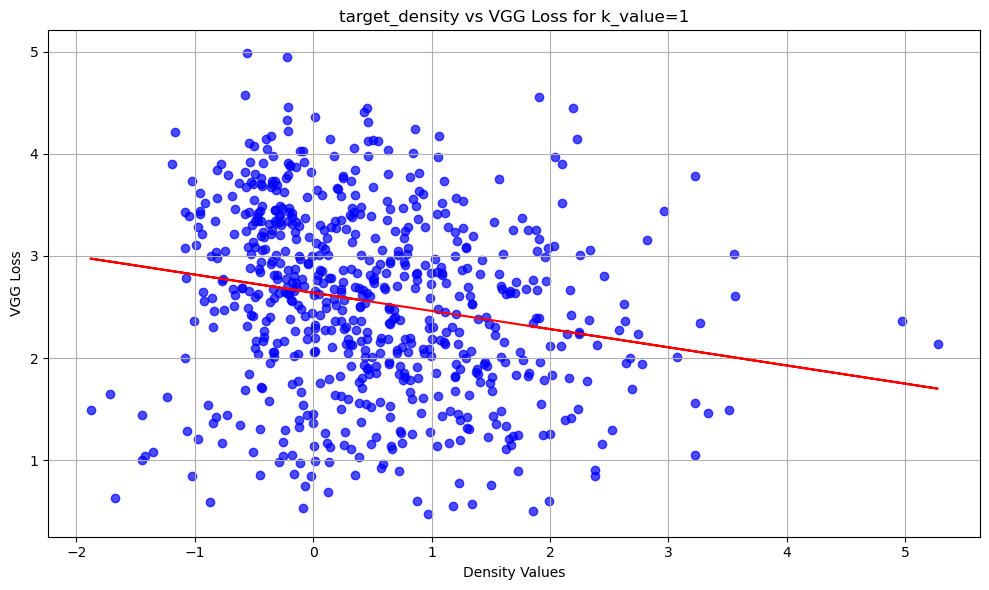

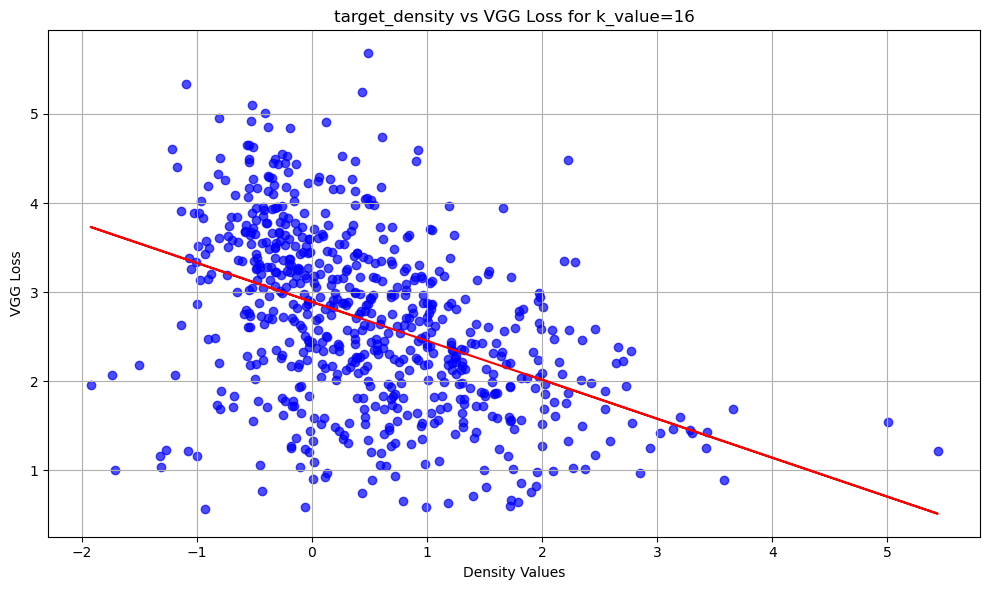

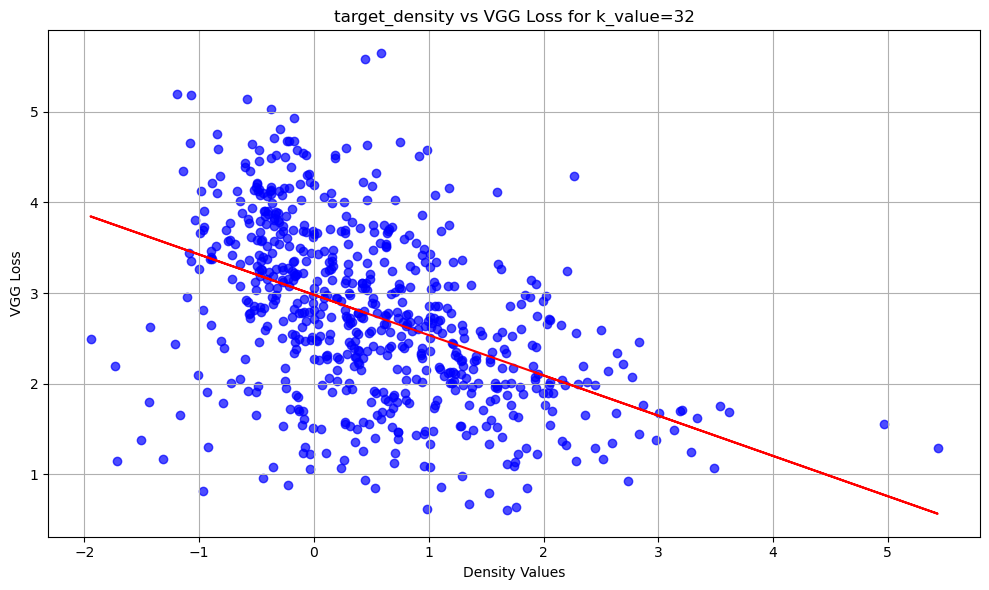

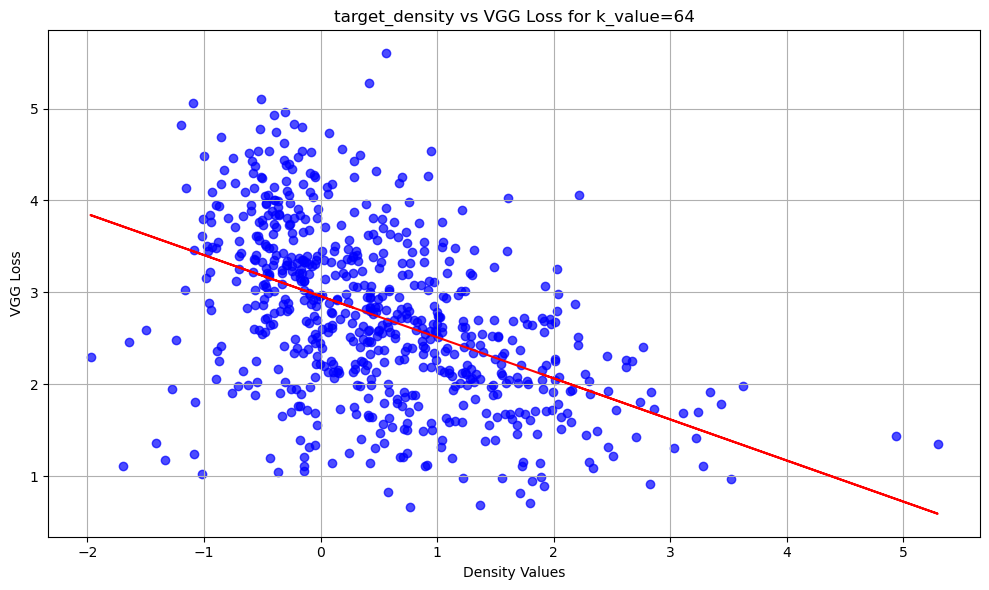

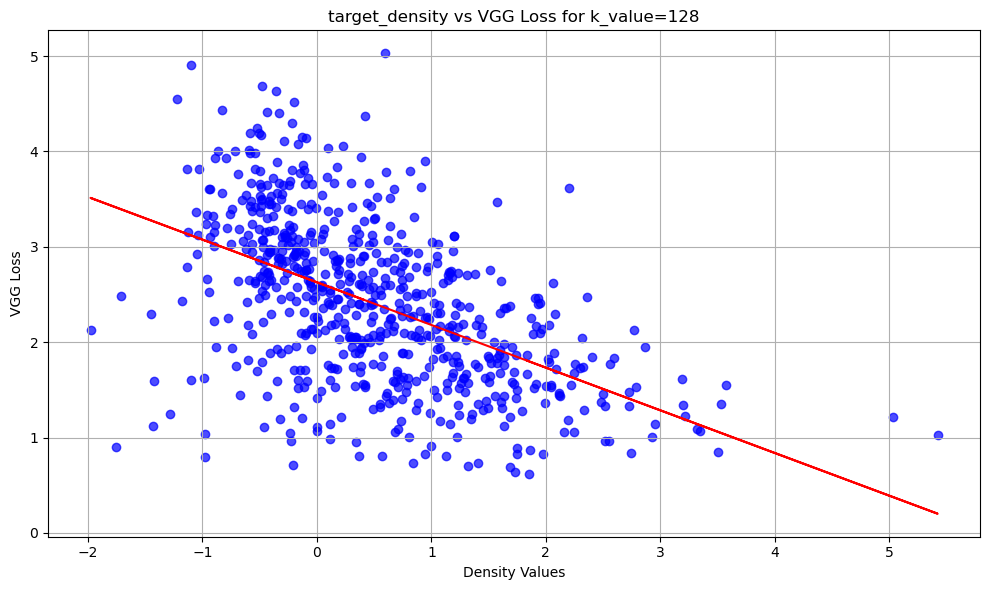

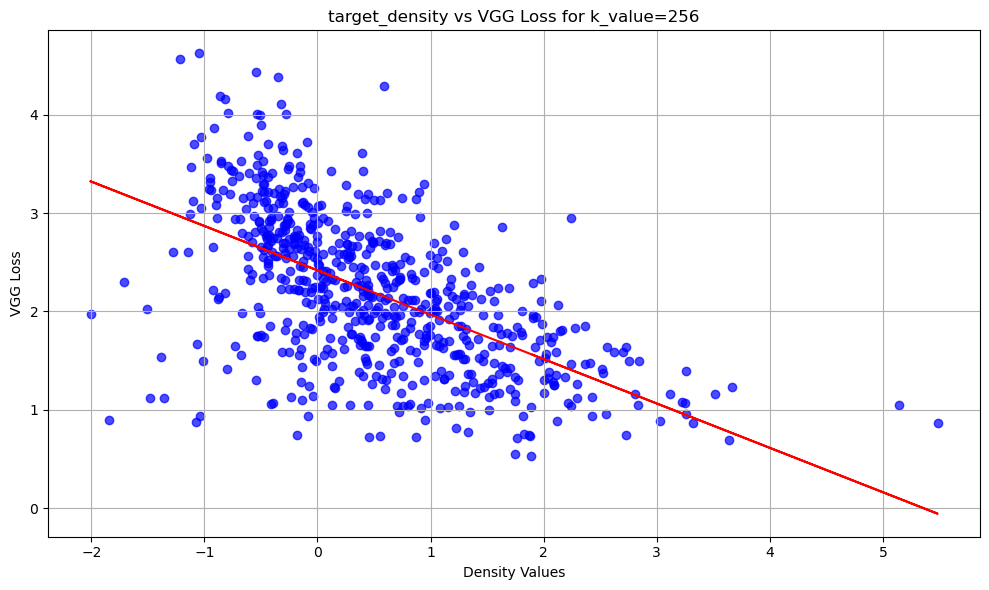

Slopes for each k_value:
k_value=1: slope=-0.18, MAE error=0.52
k_value=16: slope=-0.44, MAE error=0.23
k_value=32: slope=-0.44, MAE error=0.50
k_value=64: slope=-0.45, MAE error=0.48
k_value=128: slope=-0.45, MAE error=0.50
k_value=256: slope=-0.45, MAE error=0.49


In [60]:

slopes = {}
error = {}

# make a dictionary to hold the density values for each k_value
densities_k_values = {1: density_rf_1,
                       16: density_rf_16,
                       32: density_rf_32,
                       64: density_rf_64,
                       128: density_rf_128,
                       256: density_rf_256}

k_values = [1,16,32,64,128,256]

for k_value in k_values:
    filtered = [entry for entry in reconstruction_error if entry['k_value'] == k_value]
    #filtered = filtered[:len(density_rf_normalized)]  # Ensure we only use the first num_datapoints entries
    mse_loss = [entry['vgg_error'] for entry in filtered]

    # get the density values for the current k_value and normalize
    target_density = densities_k_values[k_value]
    target_density = (((target_density - np.mean(target_density)) / np.std(target_density))) + 0.5

    # Fit a linear regression model
    linear_regressor.fit(target_density[:min_len].reshape(-1, 1), np.array(mse_loss[:min_len]).reshape(-1, 1))
    
    # Get the slope (coefficient of LID)
    slope = linear_regressor.coef_[0]
    slopes[k_value] = slope

    # find the error between predicted loss and true loss
    y_pred = linear_regressor.predict(target_density[:min_len].reshape(-1, 1))

    error = np.abs(y_pred - np.array(mse_loss[:min_len]).reshape(-1, 1))
    average_error = np.mean(error)
    error[k_value] = average_error

    # Plot LID vs MSE loss
    plt.figure(figsize=(10, 6))

    plt.plot(target_density[:min_len], y_pred, color='red', label=f'Slope: {slope[0]:.3f}')

    plt.scatter(target_density[:min_len], mse_loss[:min_len], color='b', alpha=0.7)
    plt.xlabel("Density Values")
    plt.ylabel("VGG Loss")
    plt.title(f"target_density vs VGG Loss for k_value={k_value}")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Print slopes for each k_value
print("Slopes for each k_value:")
# Print slopes for each k_value for both normalized and non-normalized LID values
for k in k_values:
    print(f"k_value={k}: slope={slopes[k][0]:.2f}, MAE error={error[k][0]:.2f}")

In [ ]:
# see how well the linear regression fits the data
y_pred = linear_regressor.predict(density_128_normalized.reshape(-1, 1))
error = y_pred - np.array(mse_loss[:len(density_128_normalized)]).reshape(-1, 1)
print(sum(abs(error))/ len(error))

[0.48317414]


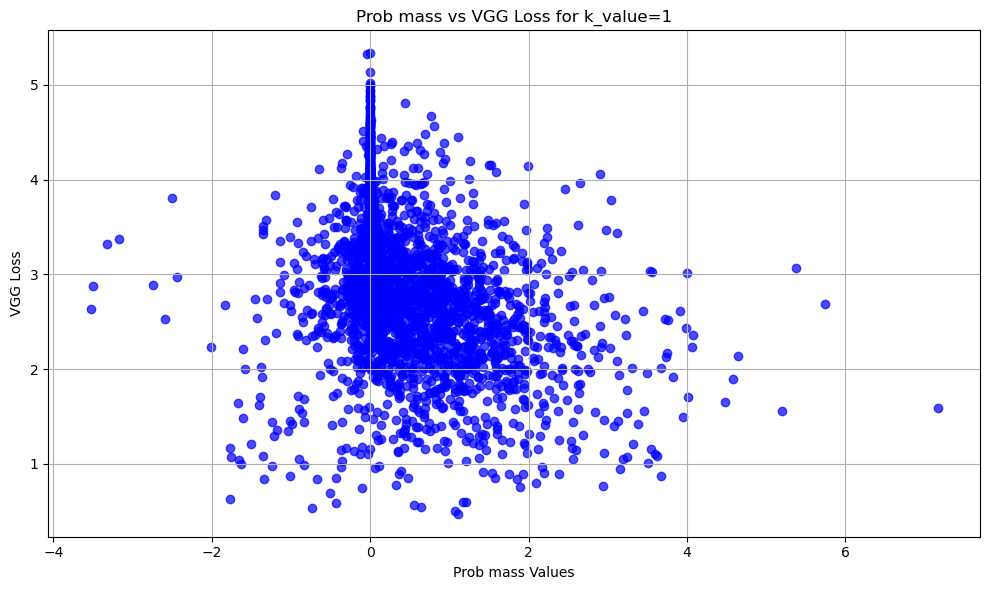

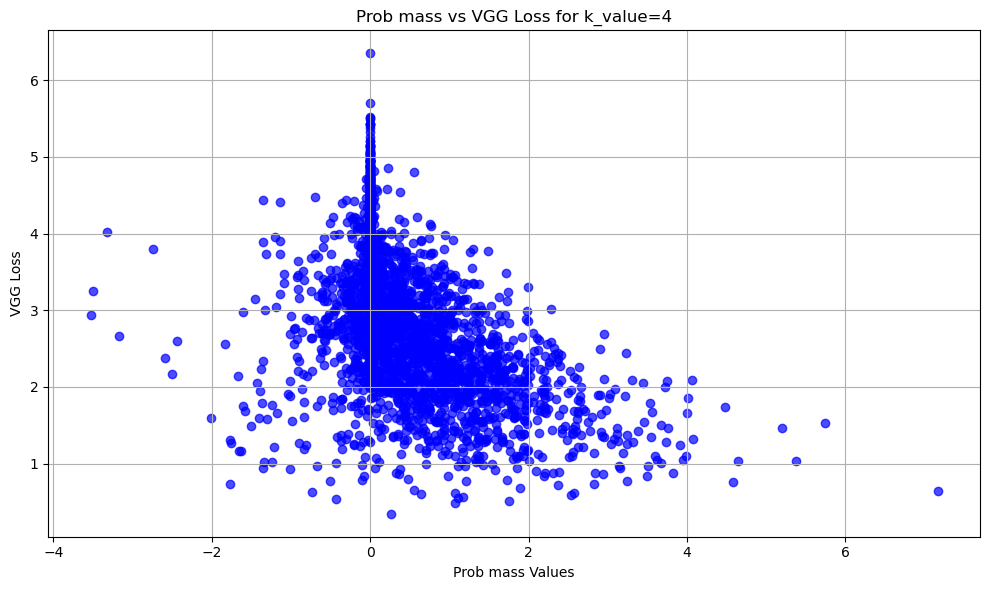

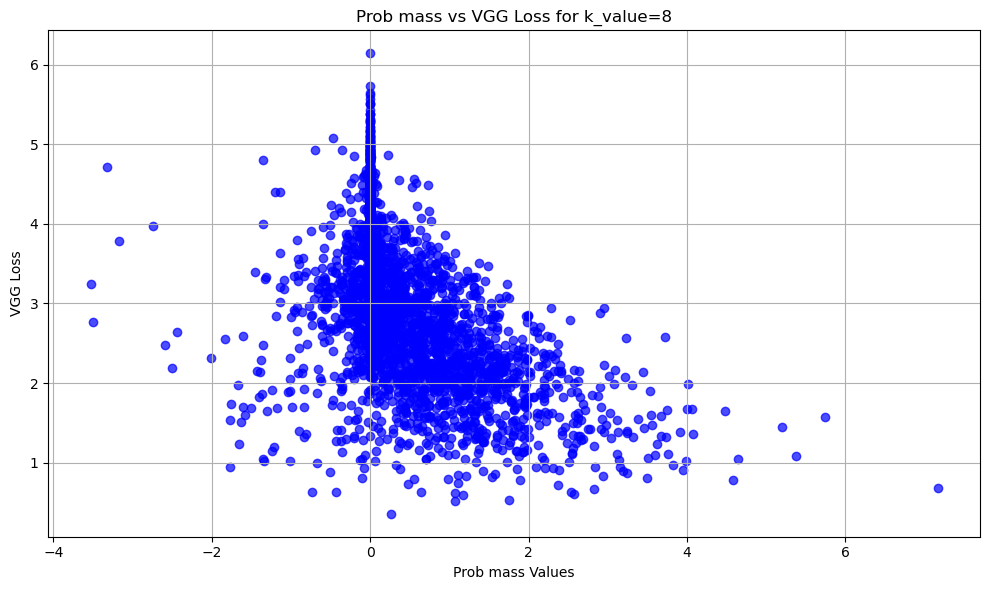

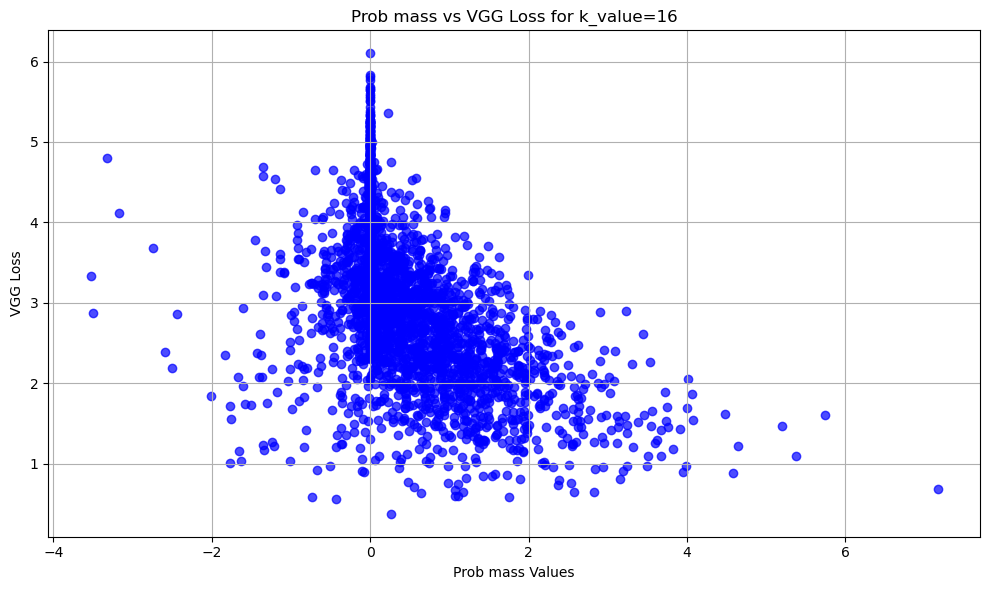

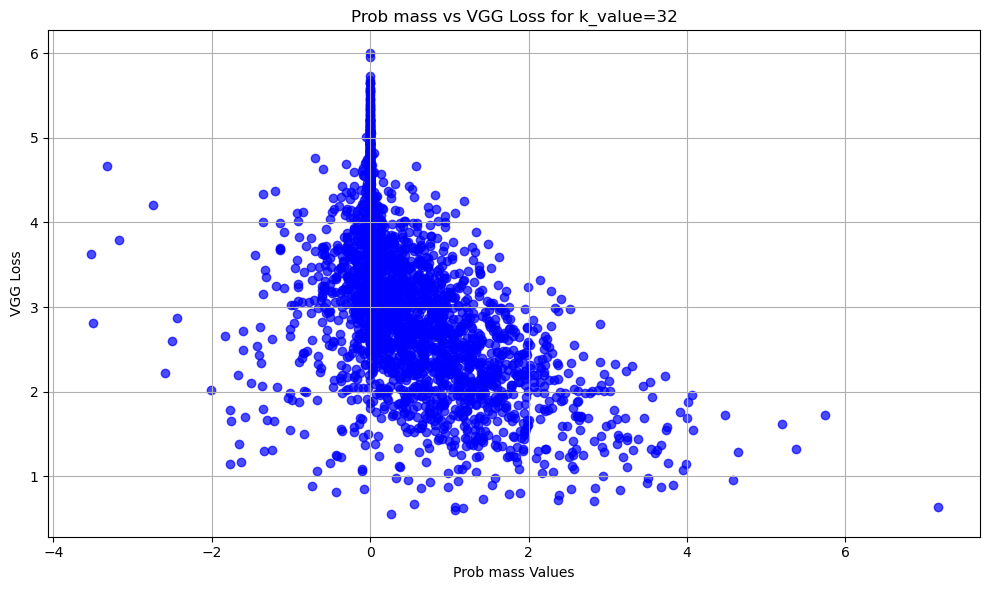

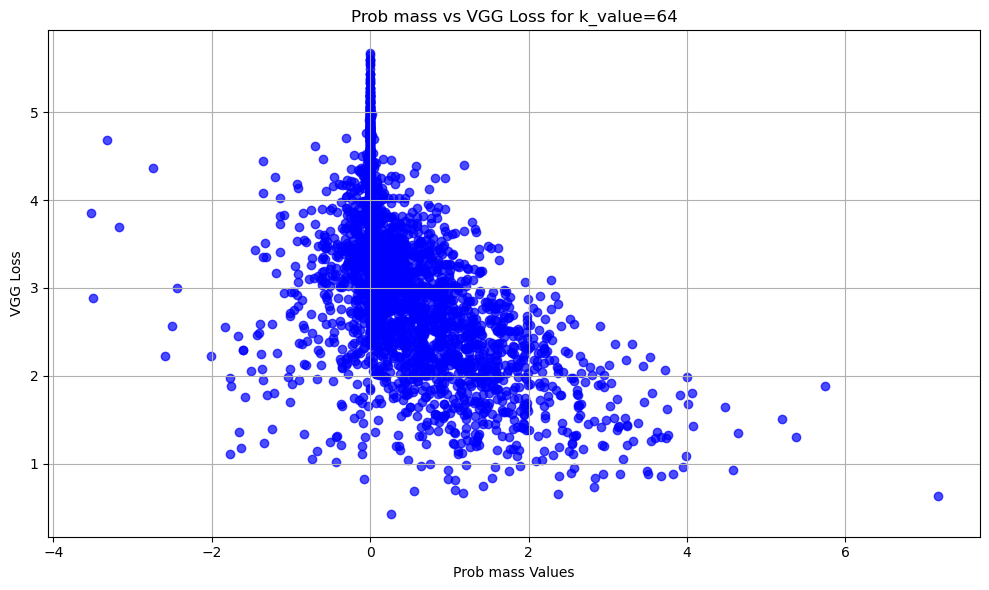

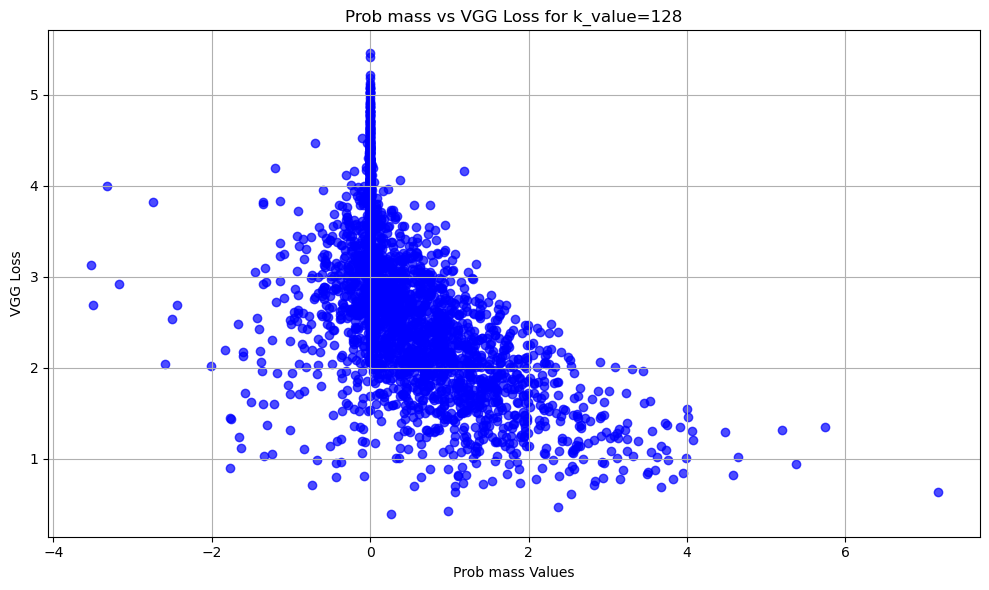

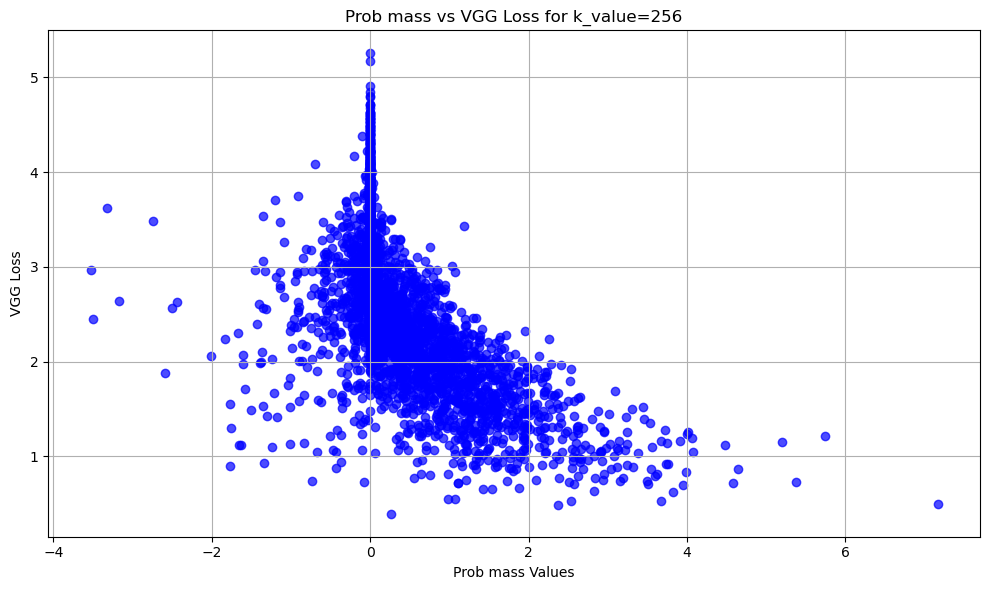

Slopes for each k_value:
k_value=1: slope=-0.31331068363560727
k_value=4: slope=-0.5275126228394107
k_value=8: slope=-0.5670205604609395
k_value=16: slope=-0.5879880512938884
k_value=32: slope=-0.5921376790270391
k_value=64: slope=-0.5995262611267295
k_value=128: slope=-0.5885798986007018
k_value=256: slope=-0.5919190931498938


In [ ]:
from sklearn.linear_model import LinearRegression


linear_regressor = LinearRegression()

slopes = {}


num_datapoints = num_images
k_values = [1,4,8,16,32,64,128,256]
for k_value in k_values:
    filtered = [entry for entry in reconstruction_error if entry['k_value'] == k_value]
    filtered = filtered[:len(density_rf_normalized)]  # Ensure we only use the first num_datapoints entries
    mse_loss = [entry['vgg_error'] for entry in filtered]
    
    lid_filtered_normalized_clipped = np.clip(lid_filtered_normalized, 0, 1)  # Clip to a minimum of 0

    #break
    prob_mass = density_rf_normalized * ((1.00-lid_filtered_normalized_clipped[:len(density_rf_normalized)]) ** lid_filtered_normalized_clipped[:len(density_rf_normalized)])

    # Fit a linear regression model
    linear_regressor.fit(np.array(prob_mass).reshape(-1, 1), np.array(mse_loss).reshape(-1, 1))

    # Get the slope (coefficient of LID)
    slope = linear_regressor.coef_[0]
    slopes[k_value] = slope

    #density_results_normalized = (((density_results - np.mean(density_results)) / np.std(density_results))) + 0.5

    # Fit a linear regression model
    # linear_regressor.fit(np.array(density_results).reshape(-1, 1), np.array(mse_loss).reshape(-1, 1))

    # # Get the slope (coefficient of LID)
    # slope = linear_regressor.coef_[0]
    # slopes_normalized[k_value] = slope


    # Plot LID vs MSE loss
    plt.figure(figsize=(10, 6))
    plt.scatter(prob_mass, mse_loss, color='b', alpha=0.7)
    plt.xlabel("Prob mass Values")
    plt.ylabel("VGG Loss")
    plt.title(f"Prob mass vs VGG Loss for k_value={k_value}")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Print slopes for each k_value
print("Slopes for each k_value:")
# Print slopes for each k_value for both normalized and non-normalized LID values
for k in k_values:
    print(f"k_value={k}: slope={slopes[k][0]}")

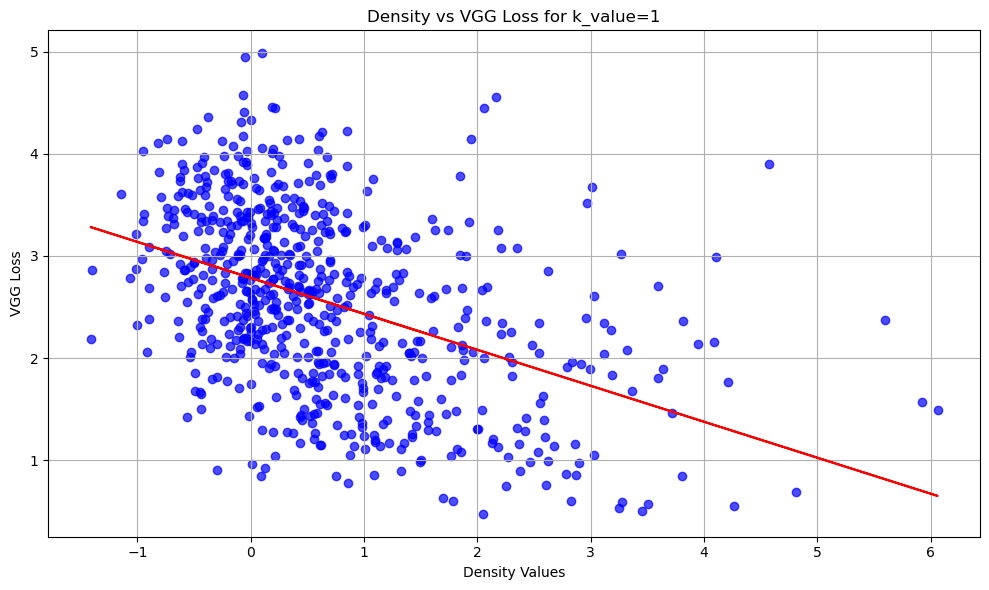

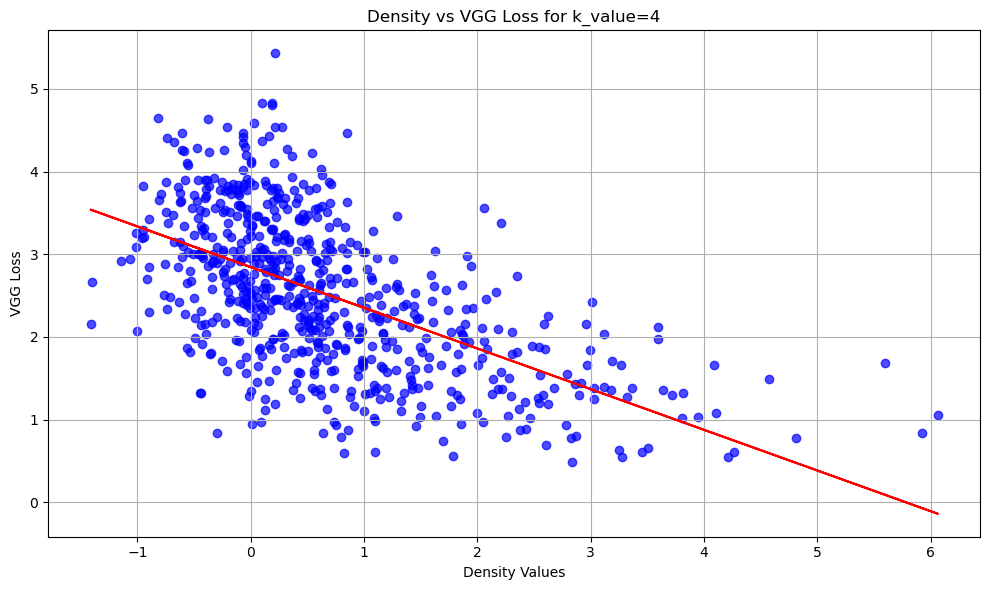

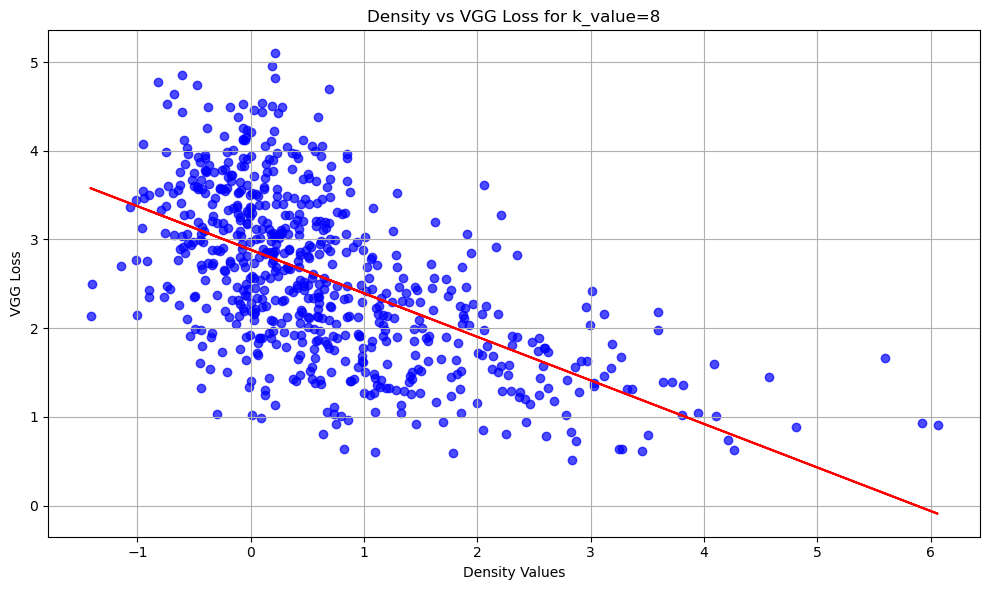

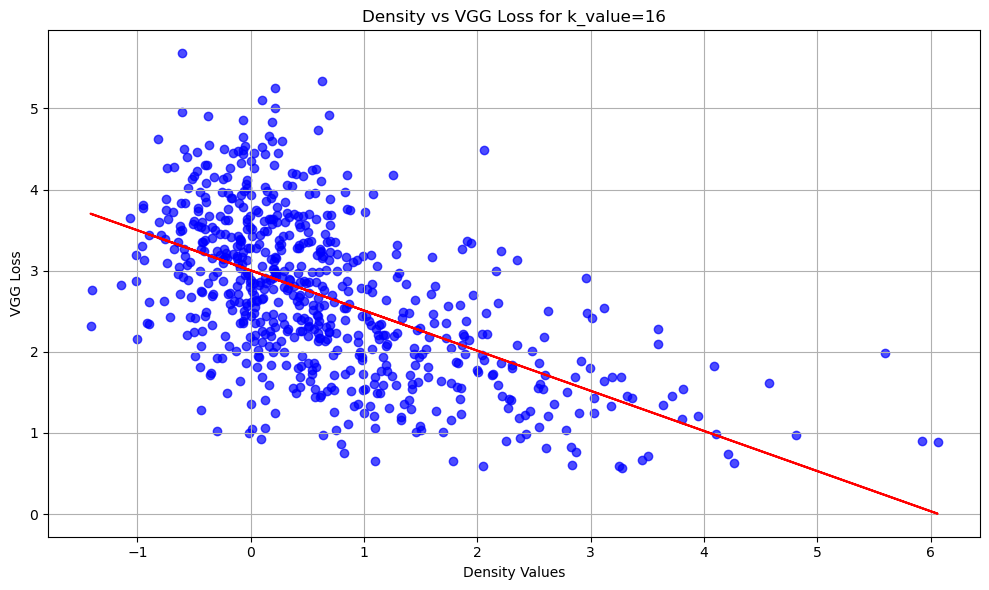

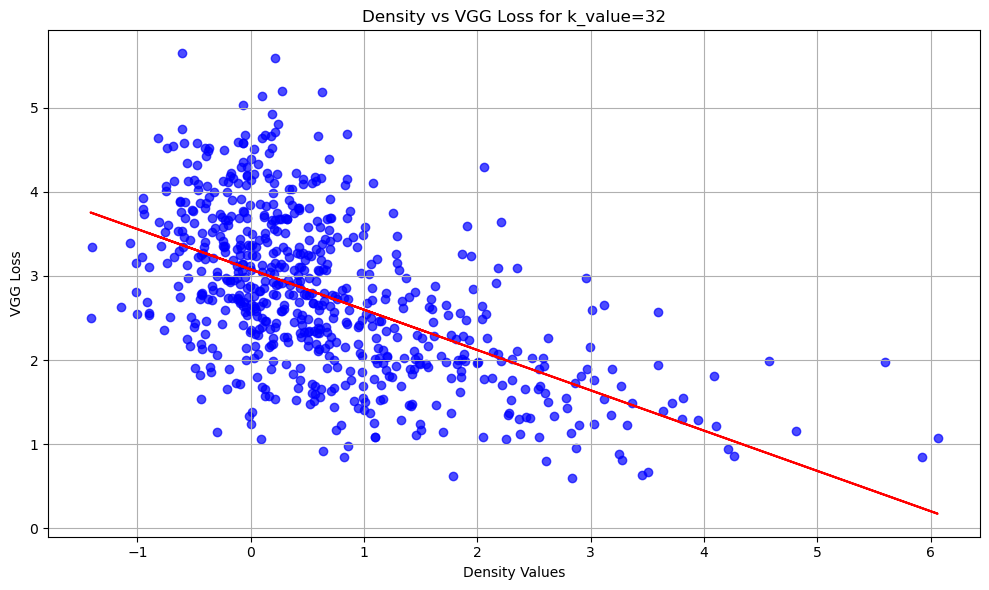

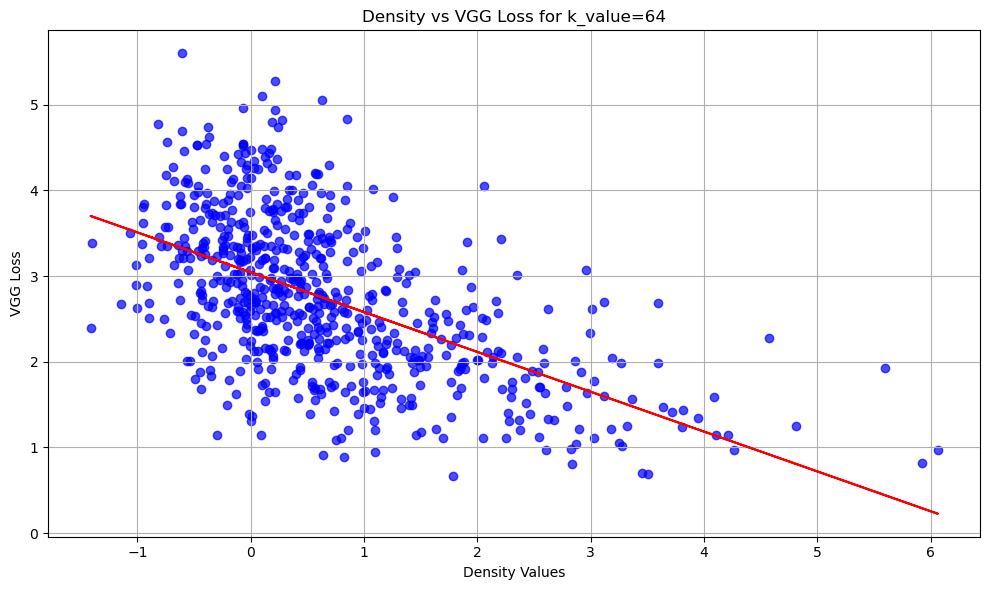

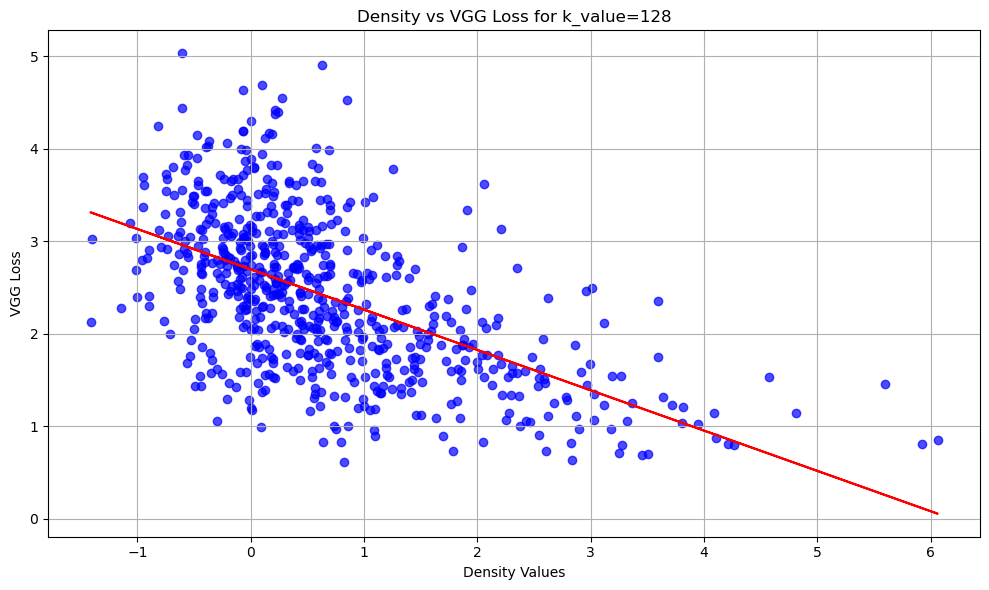

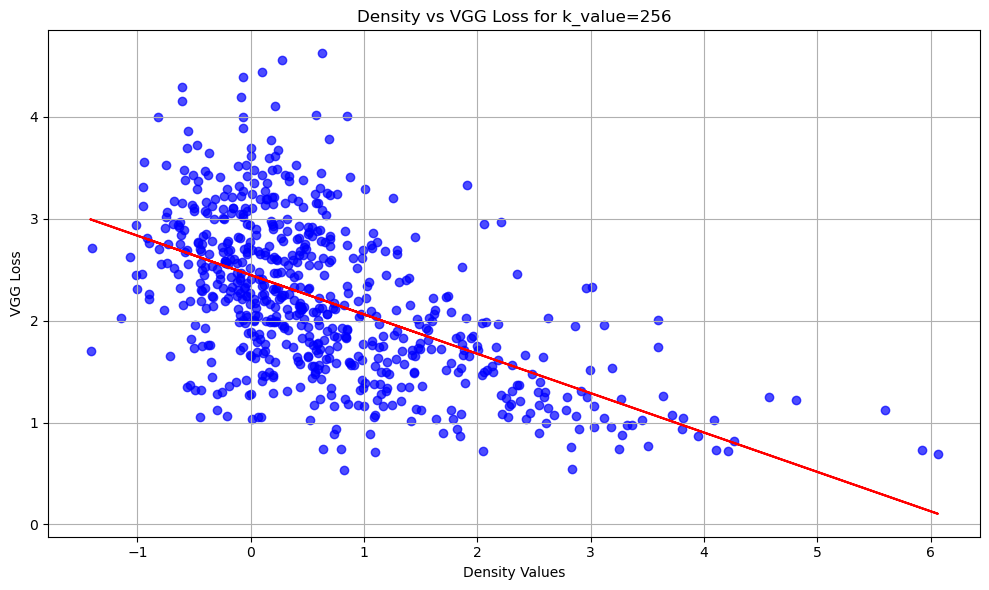

Slopes for each k_value:
k_value=1: slope=-0.35, mae error=0.24
k_value=4: slope=-0.49, mae error=0.21
k_value=8: slope=-0.49, mae error=0.06
k_value=16: slope=-0.49, mae error=0.26
k_value=32: slope=-0.48, mae error=0.56
k_value=64: slope=-0.46, mae error=0.56
k_value=128: slope=-0.44, mae error=0.18
k_value=256: slope=-0.39, mae error=0.51


In [61]:
from sklearn.linear_model import LinearRegression


linear_regressor = LinearRegression()

slopes = {}
error = {}

num_datapoints = len(density_results)
k_values = [1,4,8,16,32,64,128,256]
for k_value in k_values:
    filtered = [entry for entry in reconstruction_error if entry['k_value'] == k_value]
    filtered = filtered  # Ensure we only use the first num_datapoints entries
    mse_loss = [entry['vgg_error'] for entry in filtered]


    # Fit a linear regression model
    linear_regressor.fit(np.array(density_normalized[:min_len]).reshape(-1, 1), np.array(mse_loss[:min_len]).reshape(-1, 1))

    # Get the slope (coefficient of LID)
    slope = linear_regressor.coef_[0]
    slopes[k_value] = slope

    y_pred = linear_regressor.predict(density_normalized[:min_len].reshape(-1, 1))

    error = np.abs(y_pred - np.array(mse_loss[:min_len]).reshape(-1, 1))
    average_error = np.mean(error)
    error[k_value] = average_error

    # Plot LID vs MSE loss
    plt.figure(figsize=(10, 6))
    plt.plot(density_normalized[:min_len], y_pred, color='red', label=f'Slope: {slope[0]:.3f}')
    plt.scatter(density_normalized[:min_len], mse_loss[:min_len], color='b', alpha=0.7)
    plt.xlabel("Density Values")
    plt.ylabel("VGG Loss")
    plt.title(f"Density vs VGG Loss for k_value={k_value}")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Print slopes for each k_value
print("Slopes for each k_value:")
# Print slopes for each k_value for both normalized and non-normalized LID values
for k in k_values:
    print(f"k_value={k}: slope={slopes[k][0]:.2f}, mae error={error[k][0]:.02f}")

In [12]:
# see how well the linear regression fits the data
y_pred = linear_regressor.predict(density_normalized[:5110].reshape(-1, 1))
error = y_pred - np.array(mse_loss[:5110]).reshape(-1, 1)
print(sum(abs(error))/ len(error))

NameError: name 'density_normalized' is not defined

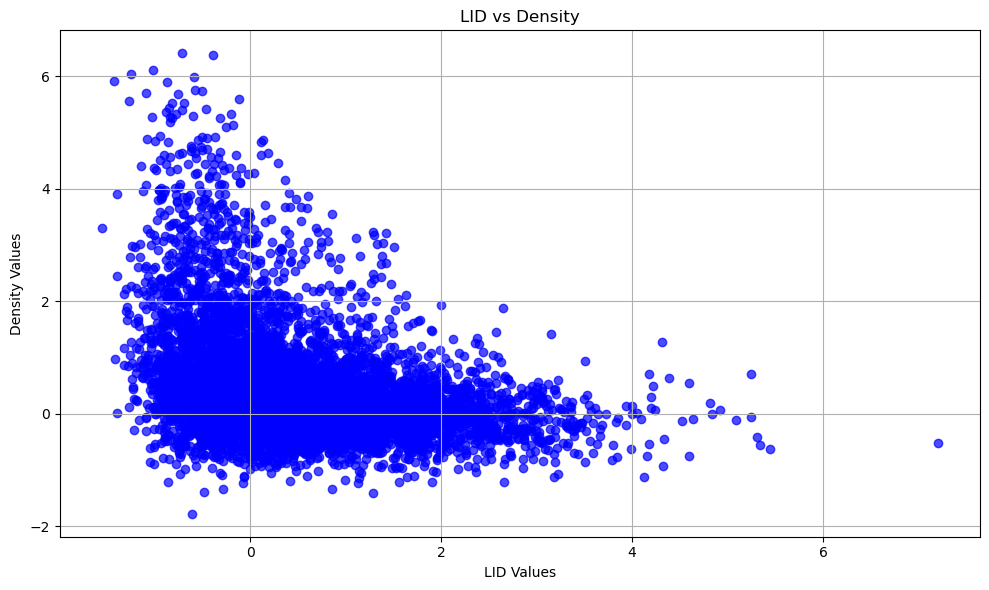

In [ ]:
# plot LID vs density
plt.figure(figsize=(10, 6))
plt.scatter(lid_filtered_normalized, density_normalized, color='b', alpha=0.7)
plt.xlabel("LID Values")
plt.ylabel("Density Values")
plt.title("LID vs Density")
plt.grid()
plt.tight_layout()
plt.show()

# of samples with density ≈ 0: 59


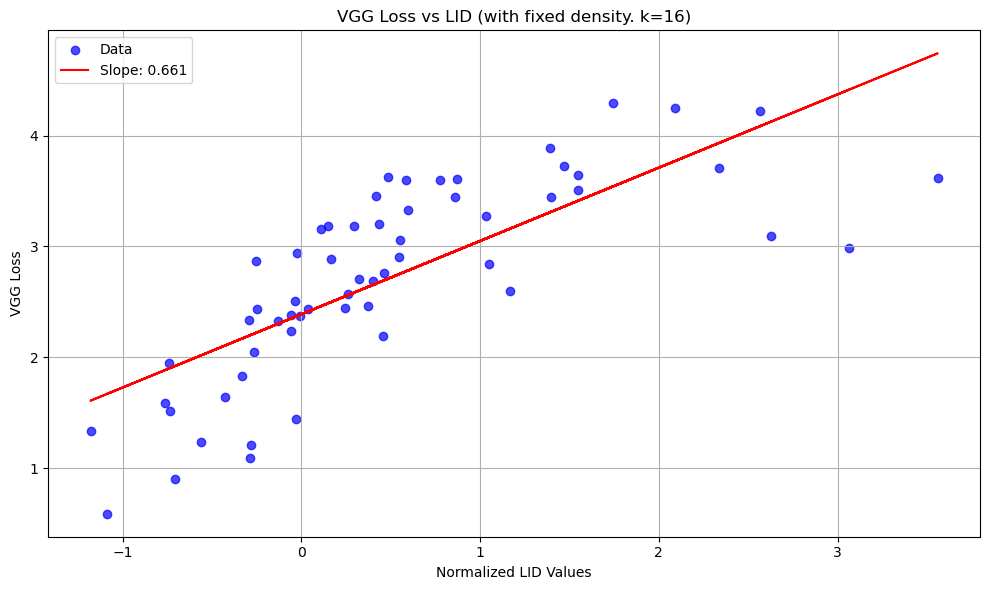

In [120]:
"""
fixing LID and checking what causes the error. Can denisty explain the error?
"""
# --- Setup ---
error_margin = 0.1  # You can try smaller like 0.05 for tighter filtering
k_value = 16     # Fixed k-value
target_lid = np.array(lid_normalized[:min_len])
# normalize the density values
density_rf_16 = np.array(density_rf_16[:min_len])
target_density = ((((density_rf_16 - np.mean(density_rf_16)) / np.std(density_rf_16))) + 0.5)[:min_len]

# Select indices where density is close to 1 (or any fixed reference value)
density_reference = 0
density_filtered_indices = np.where(
    (target_density >= density_reference - error_margin) &
    (target_density <= density_reference + error_margin)
)[0]

print(f"# of samples with density ≈ {density_reference}: {len(density_filtered_indices)}")

# Extract LID and VGG error for those indices
lid_filtered = target_lid[density_filtered_indices]

error_fixed_k = [entry for entry in reconstruction_error if entry['k_value'] == k_value]
vgg_errors = [error_fixed_k[i]['vgg_error'] for i in density_filtered_indices]

# Optional: Normalize LID to [~0.0–1.0] if you like
lid_filtered_norm = ((lid_filtered - np.mean(lid_filtered)) / np.std(lid_filtered)) + 0.5

# --- Linear regression to check correlation ---
linear_regressor = LinearRegression()
X = lid_filtered_norm.reshape(-1, 1)
y = np.array(vgg_errors).reshape(-1, 1)
linear_regressor.fit(X, y)

slope = linear_regressor.coef_[0]
y_pred = linear_regressor.predict(X)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(lid_filtered_norm, vgg_errors, alpha=0.7, color='blue', label="Data")
plt.plot(lid_filtered_norm, y_pred, color='red', label=f"Slope: {slope[0]:.3f}")
plt.xlabel("Normalized LID Values")
plt.ylabel("VGG Loss")
plt.title(f"VGG Loss vs LID (with fixed density. k={k_value})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Number of LID values within error margin of 1: 6720
368


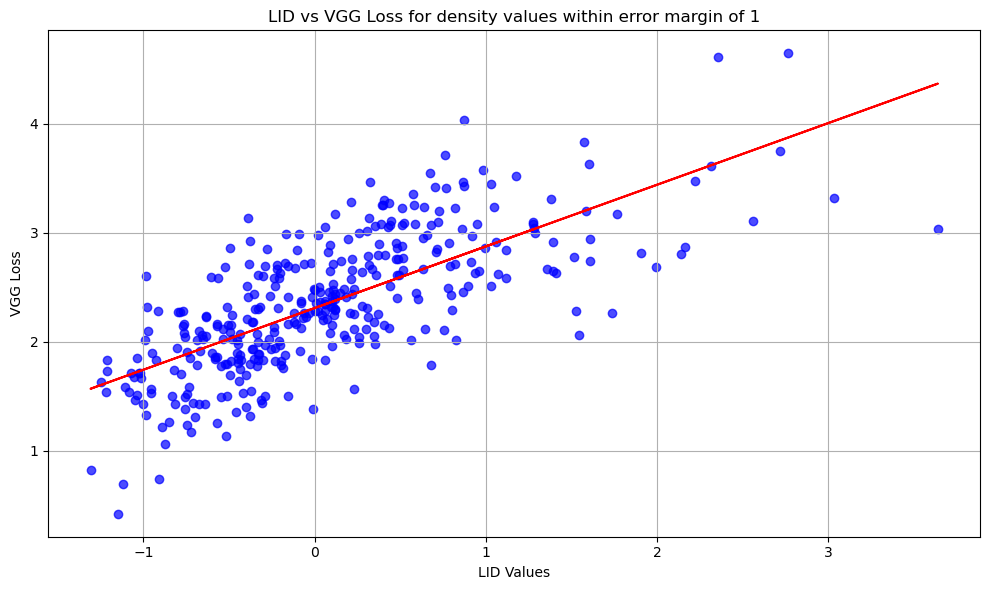

In [ ]:
"""
fixing density and checking what causes the error. Can LID explain the error?
"""
filtered_density_rf = density_rf_normalized[:len(reconstruction_error)//10]  # Ensure we only use the first num_images entries
# Define an error margin (e.g., 0.01)
error_margin = 0.1

# Filter density values within the range [1 - error_margin, 1 + error_margin]
# also return the indices of these values
density_1 = filtered_density_rf[(filtered_density_rf >= 1 - error_margin) & (filtered_density_rf <= 1 + error_margin)]
density_1_indices = np.where((filtered_density_rf >= 1 - error_margin) & (filtered_density_rf <= 1 + error_margin))[0]

# get the density values for the indices of LID values within error margin of 1
lid_1 = lid_filtered_normalized[density_1_indices]

error_fixed_k = [entry for entry in reconstruction_error if entry['k_value'] == 128]
print(f"Number of LID values within error margin of 1: {len(error_fixed_k)}")


error_filtered = [error_fixed_k[index] for index in density_1_indices]
print(len(error_filtered))

# plot density vs mse loss for the filtered LID values
plt.figure(figsize=(10, 6))
linear_regressor.fit(np.array(lid_1.reshape(-1, 1)), np.array([entry['vgg_error'] for entry in error_filtered]).reshape(-1, 1))

y_pred = linear_regressor.predict(lid_1.reshape(-1, 1))
plt.plot(lid_1, y_pred, color='red', label=f'Slope: {slope[0]:.3f}')

plt.scatter(lid_1, [entry['vgg_error'] for entry in error_filtered], color='b', alpha=0.7)
plt.xlabel("LID Values")
plt.ylabel("VGG Loss")
plt.title("LID vs VGG Loss for density values within error margin of 1")
plt.grid()
plt.tight_layout()
plt.show()

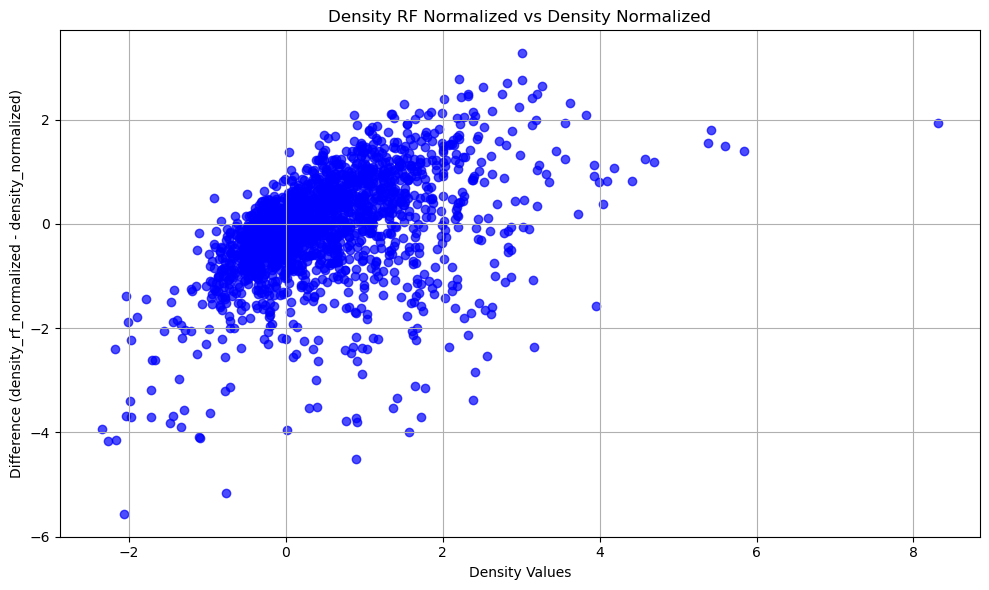

In [ ]:
# plot density_rf_normalized vs density_normalized
# they are both denisty values so i want to see how similar they are
difference = density_rf_normalized - density_normalized[:len(density_rf_normalized)]
# plot the difference
plt.figure(figsize=(10, 6))
plt.scatter(density_rf_normalized, difference, color='b', alpha=0.7)
plt.xlabel("Density Values")
plt.ylabel("Difference (density_rf_normalized - density_normalized)")
plt.title("Density RF Normalized vs Density Normalized")
plt.grid()
plt.tight_layout()
plt.show()


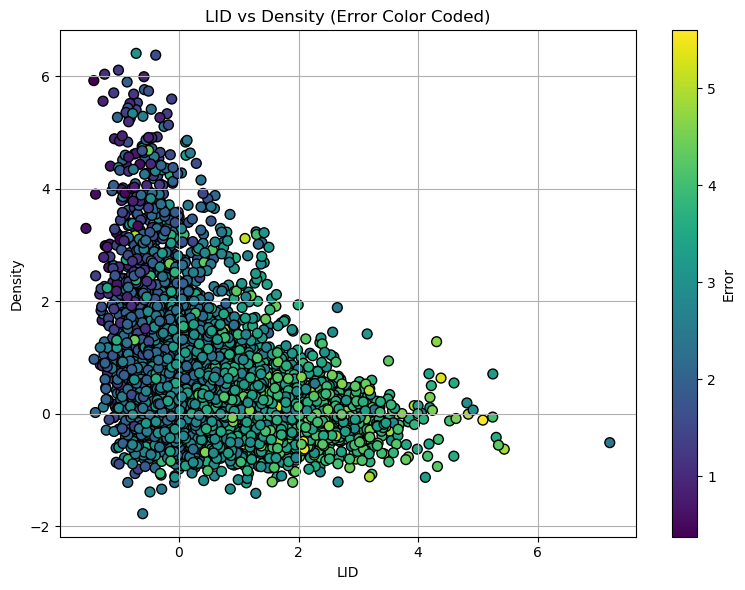

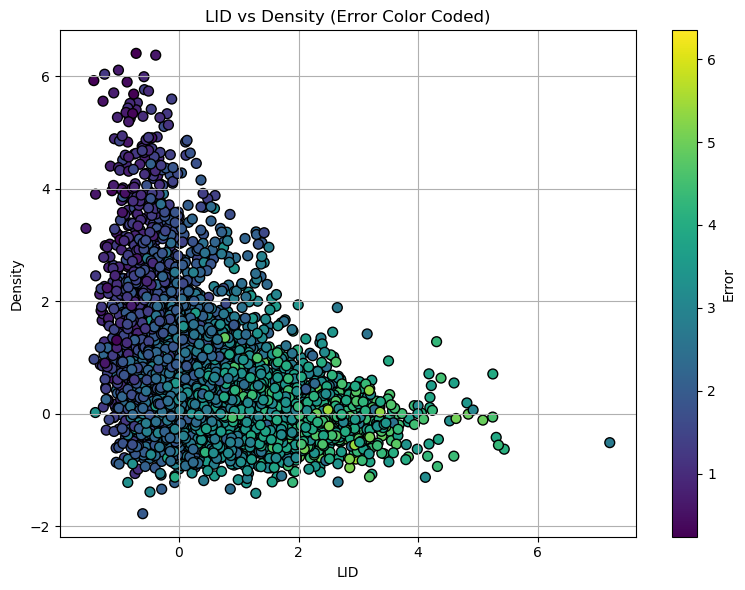

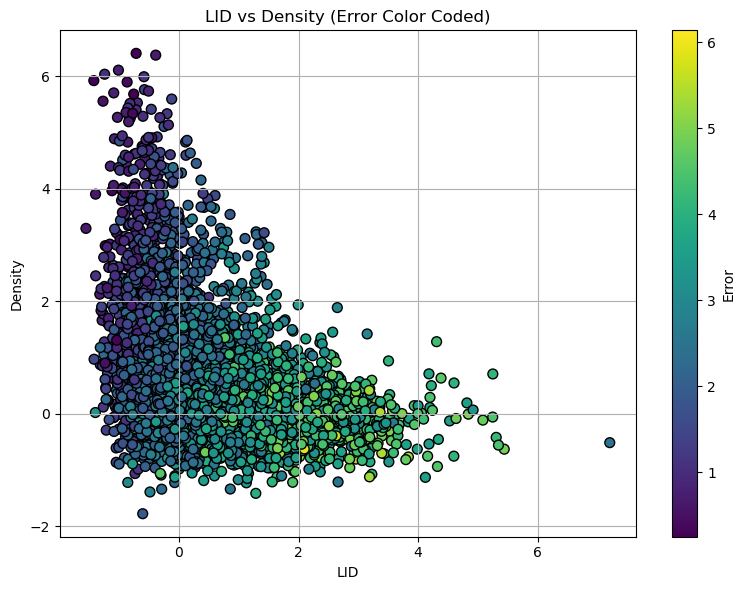

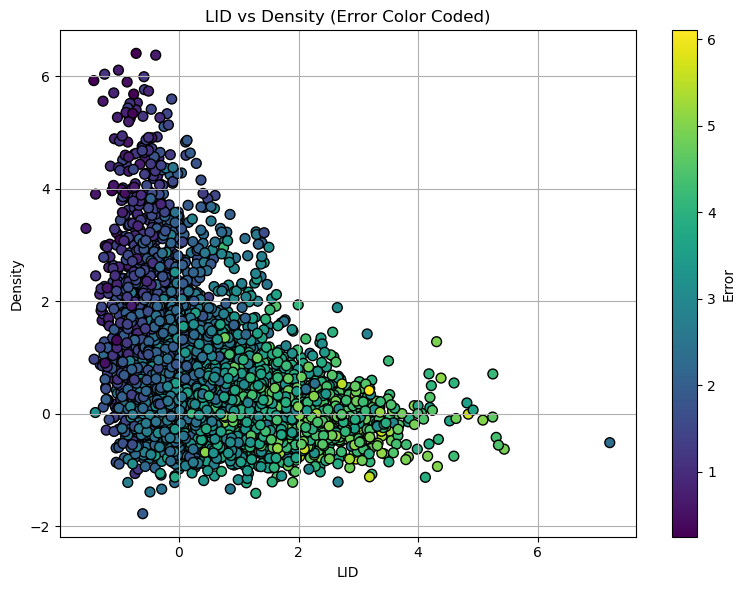

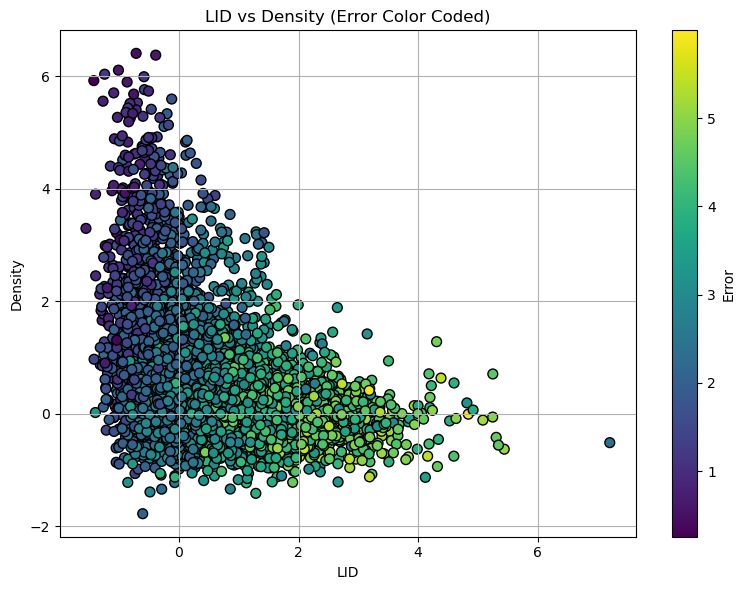

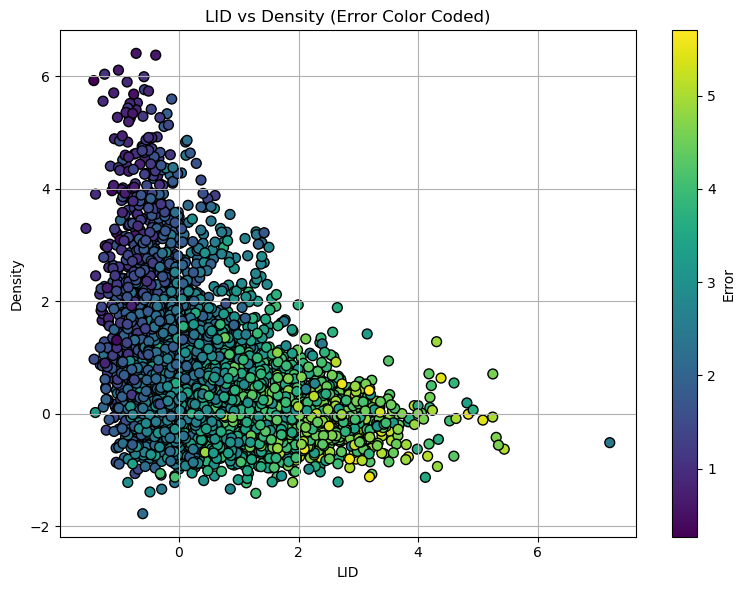

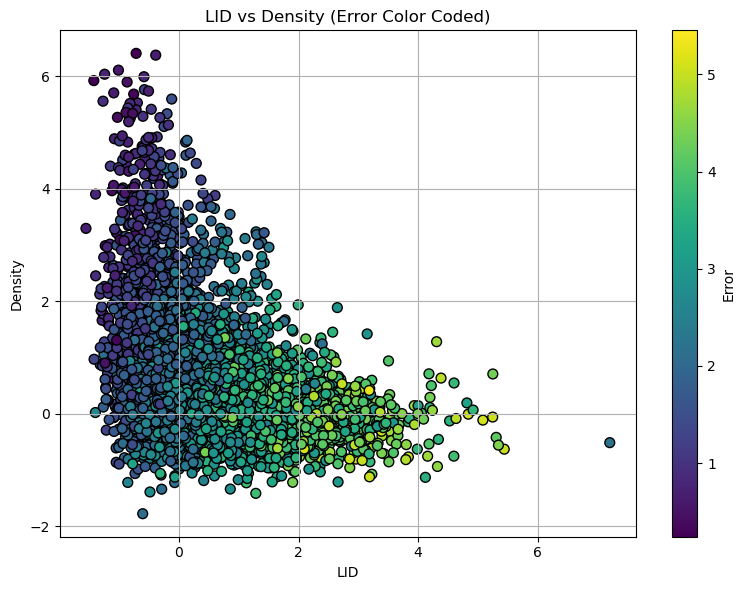

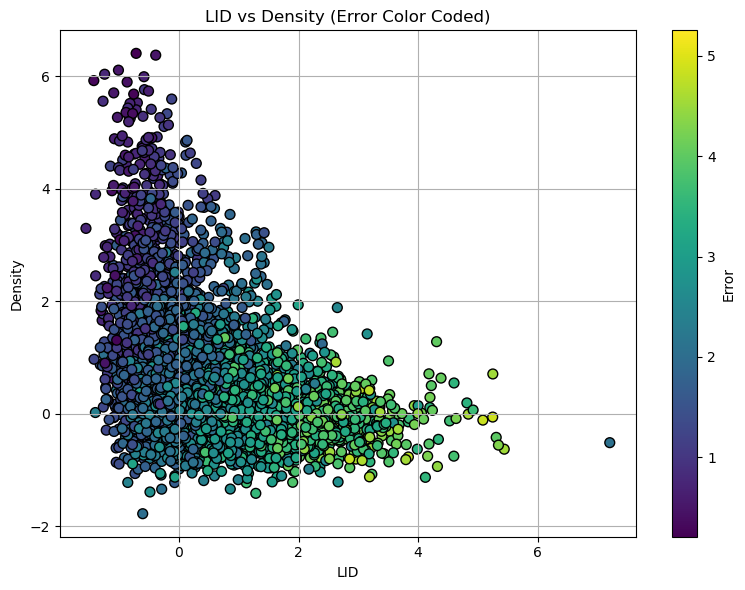

In [ ]:
for k_value in k_values:

    error = [entry['vgg_error'] for entry in reconstruction_error if entry['k_value'] == k_value]
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(lid_filtered_normalized, density_normalized, c=error, cmap='viridis', s=50, edgecolor='k')

    # Add color bar to indicate error values
    cbar = plt.colorbar(sc)
    cbar.set_label('Error')

    # Label axes
    plt.xlabel('LID')
    plt.ylabel('Density')
    plt.title('LID vs Density (Error Color Coded)')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

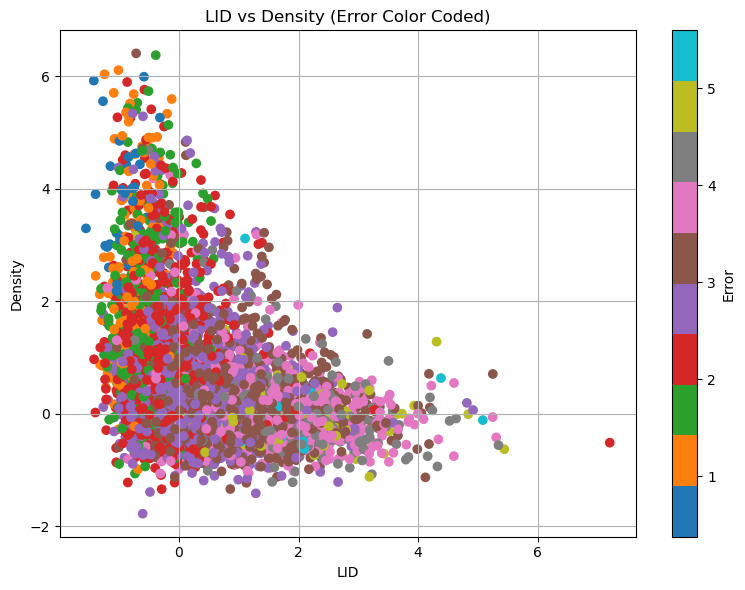

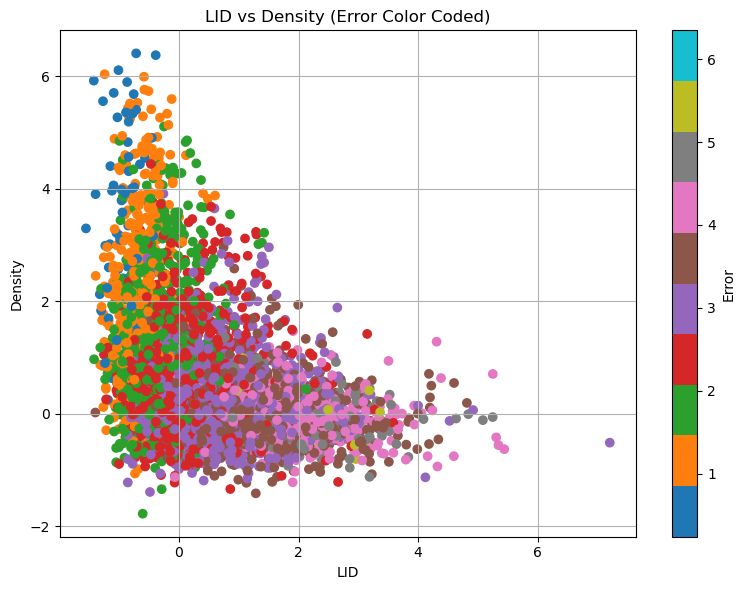

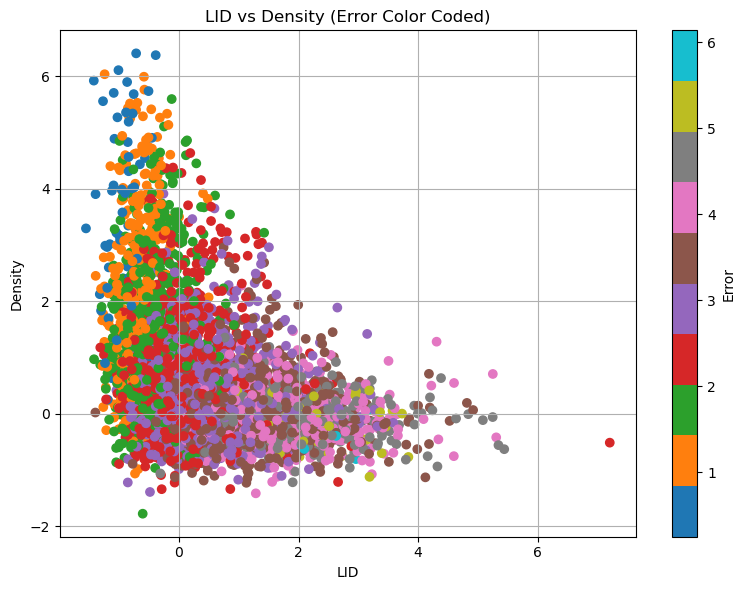

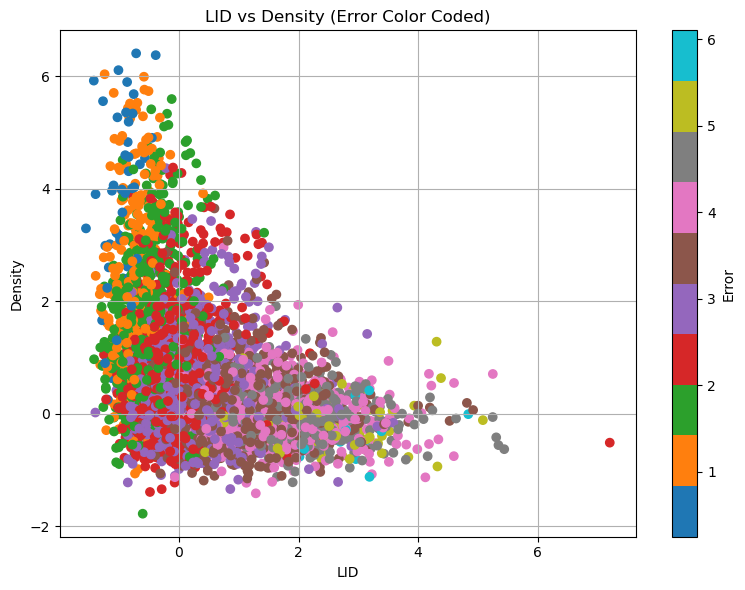

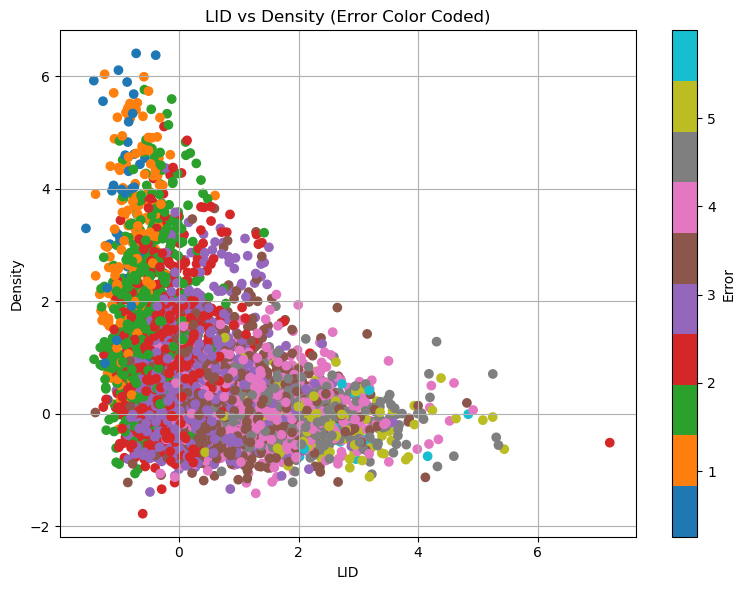

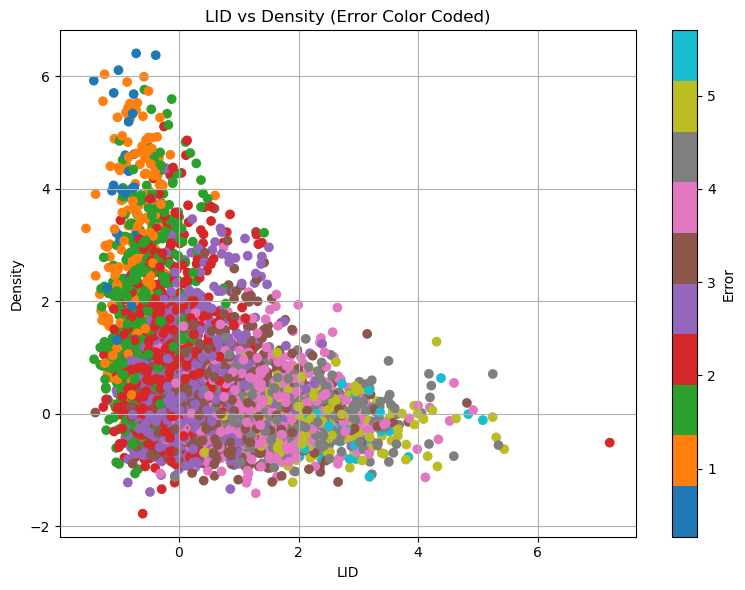

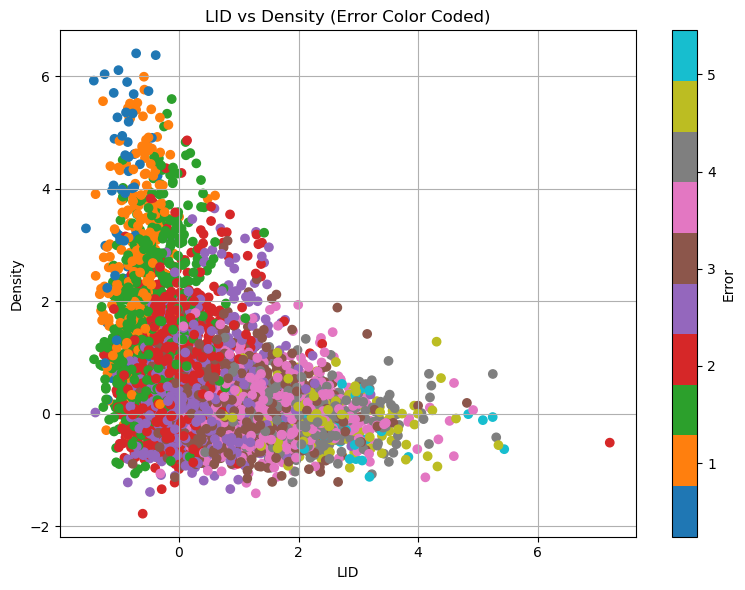

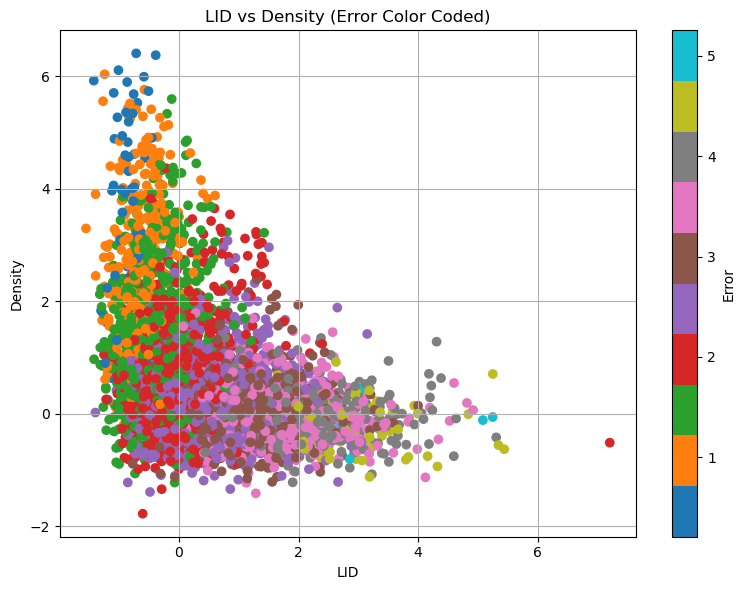

In [ ]:
for k_value in k_values:

    error = [entry['vgg_error'] for entry in reconstruction_error if entry['k_value'] == k_value]
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(lid_filtered_normalized, density_normalized, c=error, cmap='tab10')

    # Add color bar to indicate error values
    cbar = plt.colorbar(sc)
    cbar.set_label('Error')

    # Label axes
    plt.xlabel('LID')
    plt.ylabel('Density')
    plt.title('LID vs Density (Error Color Coded)')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

Silhouette Score: 0.334


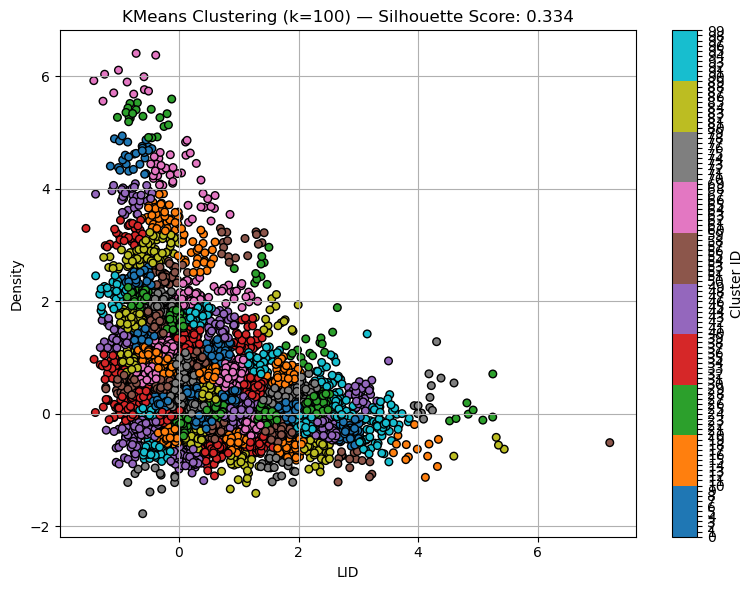

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


X = np.stack([lid_filtered_normalized, density_normalized], axis=1)  # shape: (N, 2)

# ---- Step 2: KMeans clustering ----
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# ---- Step 3: Evaluate clustering quality ----
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")

# ---- Step 4: Plot clustering result ----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(lid_filtered_normalized, density_normalized, c=cluster_labels, cmap='tab10', s=30, edgecolor='k')
plt.xlabel("LID")
plt.ylabel("Density")
plt.title(f"KMeans Clustering (k={n_clusters}) — Silhouette Score: {sil_score:.3f}")
plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster ID')
plt.grid(True)
plt.tight_layout()
plt.show()
